In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Reshape, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tqdm import tqdm
from difflib import SequenceMatcher

In [2]:
train = "train"
test = "test"
validation = "validation"

In [3]:
def read_csv(file_path):
    data = pd.read_csv(file_path)
    return data

In [4]:
train_labels = read_csv('written_name_train_v2.csv')
test_labels = read_csv('written_name_test_v2.csv')
validation_labels = read_csv('written_name_validation_v2.csv')

In [5]:
train_labels.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [6]:
test_labels.head()

,FILENAME,IDENTITY
0,TEST_0001.jpg,KEVIN
1,TEST_0002.jpg,CLOTAIRE
2,TEST_0003.jpg,LENA
3,TEST_0004.jpg,JULES
4,TEST_0005.jpg,CHERPIN


In [7]:
validation_labels.head()

,FILENAME,IDENTITY
0,VALIDATION_0001.jpg,BILEL
1,VALIDATION_0002.jpg,LAUMIONIER
2,VALIDATION_0003.jpg,LEA
3,VALIDATION_0004.jpg,JEAN-ROCH
4,VALIDATION_0005.jpg,RUPP


In [8]:
train_labels['IDENTITY'] = train_labels['IDENTITY'].str.lower().fillna('')
test_labels['IDENTITY'] = test_labels['IDENTITY'].str.lower().fillna('')
validation_labels['IDENTITY'] = validation_labels['IDENTITY'].str.lower().fillna('')

In [9]:
all_labels = pd.concat([train_labels['IDENTITY'], test_labels['IDENTITY'], validation_labels['IDENTITY']])
unique_characters = sorted(set(''.join(all_labels)))
char_to_index = {char: idx for idx, char in enumerate(unique_characters)}

In [10]:
def text_to_indices(text, mapping):
    return [mapping[char] for char in text]

In [11]:
train_labels['INDICES'] = train_labels['IDENTITY'].apply(lambda x: text_to_indices(x, char_to_index))
test_labels['INDICES'] = test_labels['IDENTITY'].apply(lambda x: text_to_indices(x, char_to_index))
validation_labels['INDICES'] = validation_labels['IDENTITY'].apply(lambda x: text_to_indices(x, char_to_index))

In [12]:
def resize_image(image, size=(128, 32)):
    return cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)

In [15]:
def read_image(folder_path, size=(128, 32)):
    images = []
    filenames = sorted(os.listdir(folder_path))
    for filename in filenames:
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        image = resize_image(image, size)
        image = image.astype('float32') / 255.0
        image = np.expand_dims(image, axis=-1)  # Add channel dimension
        images.append(image)
    return images

In [17]:
train_images = read_image("train")
test_images = read_image("test")
validation_images = read_image("validation")

In [18]:
def display_images(images, labels, title):
    plt.figure(figsize=(12, 4))
    for i in range(min(len(images), 5)):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

Sample original train images:


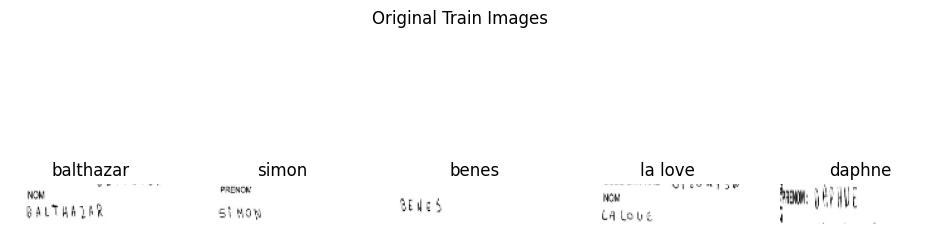

In [19]:
print("Sample original train images:")
display_images(train_images, train_labels['IDENTITY'].values[:5], "Original Train Images")

In [45]:
def augment_image(image):
    def rotate(image):
        angle = np.random.uniform(-10, 10)
        center = (image.shape[1] // 2, image.shape[0] // 2)
        matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        return cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))

    def translate(image):
        tx = np.random.uniform(-0.1 * image.shape[1], 0.1 * image.shape[1])
        ty = np.random.uniform(-0.1 * image.shape[0], 0.1 * image.shape[0])
        matrix = np.float32([[1, 0, tx], [0, 1, ty]])
        return cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))

    def scale(image):
        scale_factor = np.random.uniform(0.8, 1.2)
        return cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_LINEAR)

    def shear(image):
        shear_factor = np.random.uniform(-0.2, 0.2)
        matrix = np.array([[1, shear_factor, 0], [0, 1, 0]], dtype=np.float32)
        return cv2.warpAffine(image, matrix, (image.shape[1], image.shape[0]))

    def add_noise(image):
        noise_factor = 0.5
        noise = np.random.randn(*image.shape) * noise_factor
        noisy_image = image + noise
        noisy_image = np.clip(noisy_image, 0., 1.)
        return noisy_image

    image = rotate(image)
    image = translate(image)
    image = scale(image)
    image = shear(image)
    image = add_noise(image)
    return image

In [46]:
augmented_train_images = [augment_image(img) for img in train_images]

Sample augmented train images:


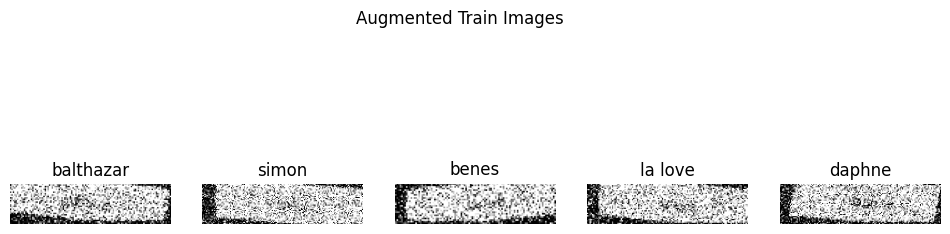

In [47]:
print("Sample augmented train images:")
display_images(augmented_train_images, train_labels['IDENTITY'].values[:5], "Augmented Train Images")

In [48]:
def generate_synthetic_image(text, font=None, image_size=(128, 32)):
    image = Image.new('L', image_size, 'white')
    draw = ImageDraw.Draw(image)
    if font is None:
        font = ImageFont.load_default()
    bbox = draw.textbbox((0, 0), text, font=font)
    width, height = bbox[2] - bbox[0], bbox[3] - bbox[1]
    position = ((image_size[0] - width) // 2, (image_size[1] - height) // 2)
    draw.text(position, text, 'black', font=font)
    image = np.array(image)
    return image.astype('float32') / 255.0

In [49]:
synthetic_train_images = [generate_synthetic_image(label) for label in train_labels['IDENTITY']]

Sample synthetic train images:


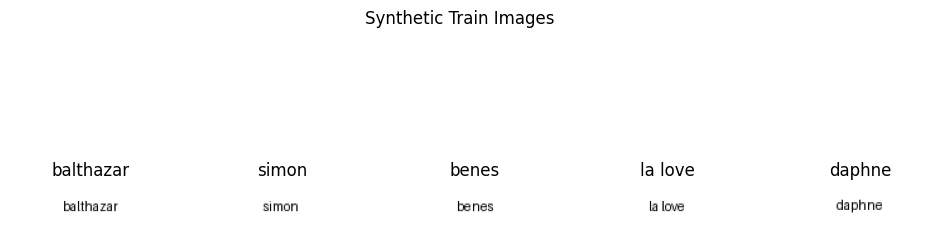

In [50]:
print("Sample synthetic train images:")
display_images(synthetic_train_images, train_labels['IDENTITY'].values[:5], "Synthetic Train Images")

In [51]:
synthetic_test_images = [generate_synthetic_image(label) for label in test_labels['IDENTITY']]

Sample synthetic test images:


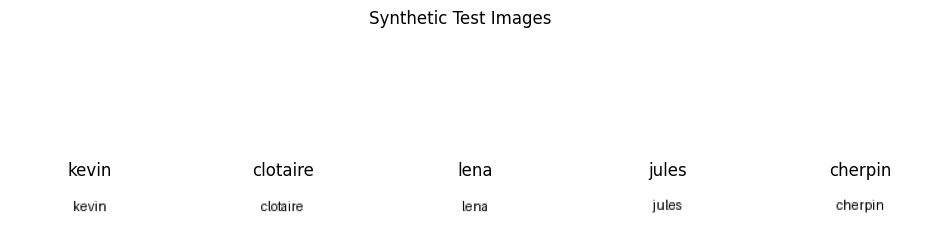

In [52]:
print("Sample synthetic test images:")
display_images(synthetic_test_images, test_labels['IDENTITY'].values[:5], "Synthetic Test Images")

In [53]:
synthetic_validation_images = [generate_synthetic_image(label) for label in validation_labels['IDENTITY']]

Sample synthetic validation images:


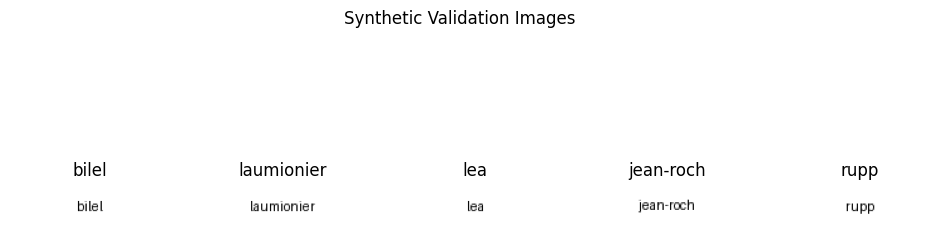

In [54]:
print("Sample synthetic validation images:")
display_images(synthetic_validation_images, validation_labels['IDENTITY'].values[:5], "Synthetic Validation Images")

In [55]:
train_images = synthetic_train_images
test_images = synthetic_test_images
validation_images = synthetic_validation_images

In [76]:
def build_crnn(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Reshape((-1, x.shape[-1]))(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.5)(x)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [77]:
input_shape = (32, 128, 1)
num_classes = len(char_to_index) + 1

In [78]:
def ctc_loss_lambda_func(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
    input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
    label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')
    return K.ctc_batch_cost(y_true, y_pred, input_length, label_length)

In [79]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

model = build_crnn(input_shape, num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

model.compile(optimizer=optimizer, loss=ctc_loss_lambda_func)

In [80]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 128, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 128, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 32, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 32, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 32, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 16, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 4, 16, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 64, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64, 31)         │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 758,943 (2.90 MB)

 Trainable params: 758,495 (2.89 MB)

 Non-trainable params: 448 (1.75 KB)

In [81]:
def filter_long_sequences(images, labels, max_len):
    filtered_images = []
    filtered_labels = []
    for img, lbl in zip(images, labels):
        if len(lbl) <= max_len:
            filtered_images.append(img)
            filtered_labels.append(lbl)
    return filtered_images, filtered_labels

In [82]:
max_output_len = (input_shape[1] // (2 ** 3))

X_train, y_train = filter_long_sequences(train_images, train_labels['INDICES'], max_output_len)
X_val, y_val = filter_long_sequences(validation_images, validation_labels['INDICES'], max_output_len)

In [83]:
def pad_sequences(sequences, maxlen=None, dtype='int32', padding='post', truncating='post', value=0):
    if maxlen is None:
        maxlen = max([len(seq) for seq in sequences])
    num_samples = len(sequences)
    x = np.full((num_samples, maxlen), value, dtype=dtype)
    for idx, seq in enumerate(sequences):
        if len(seq) == 0:
            continue
        if truncating == 'post':
            trunc = seq[:maxlen]
        elif truncating == 'pre':
            trunc = seq[-maxlen:]
        else:
            raise ValueError('Truncating type "%s" not understood' % truncating)
        trunc = np.asarray(trunc, dtype=dtype)
        if padding == 'post':
            x[idx, :len(trunc)] = trunc
        elif padding == 'pre':
            x[idx, -len(trunc):] = trunc
        else:
            raise ValueError('Padding type "%s" not understood' % padding)
    return x

In [84]:
y_train_padded = pad_sequences(y_train, maxlen=max_output_len, padding='post')
y_val_padded = pad_sequences(y_val, maxlen=max_output_len, padding='post')

In [85]:
def create_dataset(images, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [86]:
batch_size = 32

train_dataset = create_dataset(X_train, y_train_padded, batch_size=batch_size)
val_dataset = create_dataset(X_val, y_val_padded, batch_size=batch_size)

In [87]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [88]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/20
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 3329s 322ms/step - loss: 19.1269 - val_loss: 5.8093 - learning_rate: 1.0000e-04
Epoch 2/20
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 3497s 339ms/step - loss: 5.4856 - val_loss: 6.6141 - learning_rate: 1.0000e-04
Epoch 3/20
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 3600s 349ms/step - loss: 3.3367 - val_loss: 1.4913 - learning_rate: 1.0000e-04
Epoch 4/20
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 3596s 349ms/step - loss: 1.4706 - val_loss: 1.8304 - learning_rate: 1.0000e-04
Epoch 5/20
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 32106s 3s/step - loss: 1.0278 - val_loss: 0.5700 - learning_rate: 1.0000e-04
Epoch 6/20
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 3238s 314ms/step - loss: 0.7693 - val_loss: 0.4191 - learning_rate: 1.0000e-04
Epoch 7/20
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 3707s 359ms/step - loss: 0.5869 - val_loss: 0.6343 - learning_rate: 1.0000e-04
Epoch 8/20
10316/10316 ━━━━━━━━━━━━━━━━━━━━ 3435s 333ms/step - loss: 0.4766 - val_loss: 0.8469 - learning_rate: 1.0000e-04
Epoch 9/20
10316/

In [89]:
val_loss = model.evaluate(validation_dataset)
test_loss = model.evaluate(test_dataset)

1293/1293 ━━━━━━━━━━━━━━━━━━━━ 105s 81ms/step - loss: 0.1510
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 102s 79ms/step - loss: 0.1654


In [91]:
print(f"Validation loss: {val_loss:.2f}%")
print(f"Test loss: {test_loss:.2f}%")

Validation loss: 0.16%
Test loss: 0.16%


In [92]:
def calculate_cer(gt_text, pred_text):
    if len(gt_text) == 0:
        return 1.0  # If ground truth is empty, CER is 100%
    return float(sum(1 for a, b in zip(gt_text, pred_text) if a != b) + abs(len(gt_text) - len(pred_text))) / len(gt_text)

In [93]:
def calculate_wer(gt_text, pred_text):
    gt_words = gt_text.split()
    pred_words = pred_text.split()
    if len(gt_words) == 0:
        return 1.0  # If ground truth is empty, WER is 100%
    return float(sum(1 for a, b in zip(gt_words, pred_words) if a != b) + abs(len(gt_words) - len(pred_words))) / len(gt_words)

In [94]:
def decode_predictions(preds, char_map):
    decoded_preds = []
    for pred in preds:
        decoded = []
        for idx in pred:
            if idx != -1 and idx < len(char_map):  # Ensure index is valid
                decoded.append(char_map[idx])
        decoded_preds.append(''.join(decoded))
    return decoded_preds

In [95]:
def evaluate_model(model, dataset, char_map, max_output_len):
    total_cer, total_wer, total_samples = 0, 0, 0
    for batch_images, batch_labels in tqdm(dataset, desc="Evaluating", unit="batch"):
        preds = model.predict(batch_images)
        pred_indices = np.argmax(preds, axis=-1)
        decoded_preds = decode_predictions(pred_indices, char_map)
        decoded_labels = decode_predictions(batch_labels.numpy(), char_map)
        
        for gt_text, pred_text in zip(decoded_labels, decoded_preds):
            cer = calculate_cer(gt_text, pred_text)
            wer = calculate_wer(gt_text, pred_text)
            total_cer += cer
            total_wer += wer
            total_samples += 1
    
    if total_samples == 0:
        return float('inf'), float('inf'), 0.0

    avg_cer = total_cer / total_samples
    avg_wer = total_wer / total_samples
    accuracy = (1 - avg_cer) * 100
    return avg_cer, avg_wer, accuracy

In [96]:
char_to_index_reversed = {v: k for k, v in char_to_index.items()}

In [97]:
val_cer, val_wer, val_accuracy = evaluate_model(model, validation_dataset, char_to_index_reversed, max_output_len)
print(f"Validation CER: {val_cer:.4f}")
print(f"Validation WER: {val_wer:.4f}")
print(f"Validation Accuracy: {val_accuracy:.2f}%")

Evaluating:   0%|                                   | 0/1293 [00:00<?, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


Evaluating:   0%|                           | 1/1293 [00:00<11:32,  1.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Evaluating:   0%|                           | 3/1293 [00:00<04:09,  5.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Evaluating:   0%|                           | 5/1293 [00:00<02:52,  7.46batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:   1%|▏                          | 7/1293 [00:00<02:23,  8.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Evaluating:   1%|▏                          | 9/1293 [00:01<02:09,  9.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Evaluating:   1%|▏                         | 11/1293 [00:01<02:01, 10.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:   1%|▎                         | 13/1293 [00:01<01:55, 11.04batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:   1%|▎                         | 15/1293 [00:01<01:55, 11.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:   1%|▎                         | 17/1293 [00:01<01:52, 11.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:   1%|▍                         | 19/1293 [00:02<01:50, 11.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluating:   2%|▍                         | 21/1293 [00:02<01:48, 11.75batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:   2%|▍                         | 23/1293 [00:02<01:47, 11.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:   2%|▌                         | 25/1293 [00:02<01:50, 11.49batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Evaluating:   2%|▌                         | 27/1293 [00:02<01:49, 11.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Evaluating:   2%|▌                         | 29/1293 [00:02<01:44, 12.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Evaluating:   2%|▌                         | 31/1293 [00:03<01:43, 12.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:   3%|▋                         | 33/1293 [00:03<01:41, 12.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Evaluating:   3%|▋                         | 35/1293 [00:03<01:42, 12.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Evaluating:   3%|▋                         | 37/1293 [00:03<01:42, 12.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:   3%|▊                         | 39/1293 [00:03<01:42, 12.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Evaluating:   3%|▊                         | 41/1293 [00:03<01:44, 11.96batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


Evaluating:   3%|▊                         | 43/1293 [00:04<01:46, 11.71batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Evaluating:   3%|▉                         | 45/1293 [00:04<01:47, 11.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:   4%|▉                         | 47/1293 [00:04<01:46, 11.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:   4%|▉                         | 49/1293 [00:04<01:47, 11.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Evaluating:   4%|█                         | 51/1293 [00:04<01:51, 11.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:   4%|█                         | 53/1293 [00:04<01:51, 11.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Evaluating:   4%|█                         | 55/1293 [00:05<01:50, 11.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:   4%|█▏                        | 57/1293 [00:05<01:49, 11.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:   5%|█▏                        | 59/1293 [00:05<01:48, 11.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluating:   5%|█▏                        | 61/1293 [00:05<01:49, 11.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Evaluating:   5%|█▎                        | 63/1293 [00:05<01:50, 11.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


Evaluating:   5%|█▎                        | 65/1293 [00:05<01:45, 11.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:   5%|█▎                        | 67/1293 [00:06<01:45, 11.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:   5%|█▍                        | 69/1293 [00:06<01:45, 11.58batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:   5%|█▍                        | 71/1293 [00:06<01:45, 11.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:   6%|█▍                        | 73/1293 [00:06<01:43, 11.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:   6%|█▌                        | 75/1293 [00:06<01:44, 11.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Evaluating:   6%|█▌                        | 77/1293 [00:06<01:41, 11.97batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:   6%|█▌                        | 79/1293 [00:07<01:44, 11.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:   6%|█▋                        | 81/1293 [00:07<01:46, 11.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:   6%|█▋                        | 83/1293 [00:07<01:46, 11.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:   7%|█▋                        | 85/1293 [00:07<01:45, 11.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


Evaluating:   7%|█▋                        | 87/1293 [00:07<01:44, 11.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:   7%|█▊                        | 89/1293 [00:08<01:44, 11.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


Evaluating:   7%|█▊                        | 91/1293 [00:08<01:38, 12.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Evaluating:   7%|█▊                        | 93/1293 [00:08<01:34, 12.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:   7%|█▉                        | 95/1293 [00:08<01:36, 12.46batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:   8%|█▉                        | 97/1293 [00:08<01:40, 11.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:   8%|█▉                        | 99/1293 [00:08<01:53, 10.47batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:   8%|█▉                       | 101/1293 [00:09<02:05,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:   8%|█▉                       | 102/1293 [00:09<02:08,  9.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:   8%|█▉                       | 103/1293 [00:09<02:09,  9.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:   8%|██                       | 104/1293 [00:09<02:11,  9.06batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:   8%|██                       | 105/1293 [00:09<02:11,  9.02batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:   8%|██                       | 106/1293 [00:09<02:10,  9.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:   8%|██                       | 108/1293 [00:09<02:02,  9.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Evaluating:   8%|██                       | 109/1293 [00:10<02:12,  8.94batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Evaluating:   9%|██▏                      | 110/1293 [00:10<02:16,  8.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Evaluating:   9%|██▏                      | 111/1293 [00:10<02:21,  8.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:   9%|██▏                      | 112/1293 [00:10<02:21,  8.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:   9%|██▏                      | 113/1293 [00:10<02:21,  8.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:   9%|██▏                      | 115/1293 [00:10<02:07,  9.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Evaluating:   9%|██▏                      | 116/1293 [00:10<02:12,  8.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Evaluating:   9%|██▎                      | 117/1293 [00:11<02:19,  8.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:   9%|██▎                      | 119/1293 [00:11<02:12,  8.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Evaluating:   9%|██▎                      | 120/1293 [00:11<02:15,  8.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:   9%|██▎                      | 121/1293 [00:11<02:16,  8.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Evaluating:   9%|██▎                      | 122/1293 [00:11<02:19,  8.42batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  10%|██▍                      | 123/1293 [00:11<02:19,  8.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  10%|██▍                      | 124/1293 [00:11<02:18,  8.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Evaluating:  10%|██▍                      | 126/1293 [00:12<02:15,  8.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Evaluating:  10%|██▍                      | 127/1293 [00:12<02:21,  8.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Evaluating:  10%|██▍                      | 128/1293 [00:12<02:26,  7.93batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:  10%|██▍                      | 129/1293 [00:12<02:26,  7.93batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Evaluating:  10%|██▌                      | 130/1293 [00:12<02:27,  7.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  10%|██▌                      | 131/1293 [00:12<02:25,  8.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Evaluating:  10%|██▌                      | 132/1293 [00:12<02:26,  7.92batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  10%|██▌                      | 133/1293 [00:12<02:22,  8.16batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  10%|██▌                      | 135/1293 [00:13<02:10,  8.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  11%|██▋                      | 137/1293 [00:13<01:59,  9.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  11%|██▋                      | 138/1293 [00:13<02:01,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  11%|██▋                      | 139/1293 [00:13<02:02,  9.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  11%|██▋                      | 141/1293 [00:13<02:00,  9.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  11%|██▋                      | 142/1293 [00:13<02:02,  9.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  11%|██▊                      | 144/1293 [00:14<01:59,  9.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  11%|██▊                      | 146/1293 [00:14<01:54, 10.02batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  11%|██▊                      | 147/1293 [00:14<01:59,  9.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  11%|██▊                      | 148/1293 [00:14<02:01,  9.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  12%|██▉                      | 149/1293 [00:14<02:03,  9.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  12%|██▉                      | 150/1293 [00:14<02:04,  9.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  12%|██▉                      | 151/1293 [00:14<02:04,  9.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  12%|██▉                      | 152/1293 [00:14<02:05,  9.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  12%|██▉                      | 153/1293 [00:15<02:05,  9.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  12%|██▉                      | 154/1293 [00:15<02:06,  9.00batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  12%|██▉                      | 155/1293 [00:15<02:07,  8.96batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Evaluating:  12%|███                      | 156/1293 [00:15<02:12,  8.58batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  12%|███                      | 157/1293 [00:15<02:13,  8.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:  12%|███                      | 158/1293 [00:15<02:15,  8.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  12%|███                      | 159/1293 [00:15<02:12,  8.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  12%|███                      | 160/1293 [00:15<02:12,  8.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  13%|███▏                     | 162/1293 [00:16<02:06,  8.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  13%|███▏                     | 163/1293 [00:16<02:07,  8.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  13%|███▏                     | 164/1293 [00:16<02:07,  8.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  13%|███▏                     | 165/1293 [00:16<02:09,  8.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  13%|███▏                     | 167/1293 [00:16<02:03,  9.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  13%|███▏                     | 168/1293 [00:16<02:04,  9.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  13%|███▎                     | 169/1293 [00:16<02:01,  9.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  13%|███▎                     | 171/1293 [00:17<01:52,  9.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  13%|███▎                     | 173/1293 [00:17<01:49, 10.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  14%|███▍                     | 175/1293 [00:17<01:49, 10.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  14%|███▍                     | 177/1293 [00:17<01:53,  9.80batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  14%|███▍                     | 179/1293 [00:17<01:49, 10.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  14%|███▍                     | 181/1293 [00:17<01:47, 10.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  14%|███▌                     | 183/1293 [00:18<01:52,  9.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  14%|███▌                     | 185/1293 [00:18<01:47, 10.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  14%|███▌                     | 187/1293 [00:18<01:49, 10.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  15%|███▋                     | 189/1293 [00:18<01:53,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  15%|███▋                     | 190/1293 [00:18<01:56,  9.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  15%|███▋                     | 191/1293 [00:19<01:59,  9.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Evaluating:  15%|███▋                     | 193/1293 [00:19<02:00,  9.12batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  15%|███▊                     | 195/1293 [00:19<01:53,  9.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  15%|███▊                     | 196/1293 [00:19<01:55,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  15%|███▊                     | 198/1293 [00:19<01:54,  9.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  15%|███▊                     | 199/1293 [00:19<01:57,  9.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  16%|███▉                     | 201/1293 [00:20<01:55,  9.49batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  16%|███▉                     | 202/1293 [00:20<01:56,  9.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  16%|███▉                     | 203/1293 [00:20<01:58,  9.16batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  16%|███▉                     | 204/1293 [00:20<01:59,  9.09batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:  16%|███▉                     | 205/1293 [00:20<02:04,  8.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  16%|███▉                     | 206/1293 [00:20<02:06,  8.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Evaluating:  16%|████                     | 207/1293 [00:20<02:09,  8.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  16%|████                     | 209/1293 [00:21<02:03,  8.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Evaluating:  16%|████                     | 211/1293 [00:21<02:00,  8.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  16%|████                     | 212/1293 [00:21<02:02,  8.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:  16%|████                     | 213/1293 [00:21<02:06,  8.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  17%|████▏                    | 214/1293 [00:21<02:05,  8.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  17%|████▏                    | 215/1293 [00:21<02:04,  8.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  17%|████▏                    | 217/1293 [00:21<01:57,  9.12batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  17%|████▏                    | 218/1293 [00:22<01:58,  9.06batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  17%|████▏                    | 219/1293 [00:22<01:59,  8.97batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  17%|████▎                    | 220/1293 [00:22<02:01,  8.82batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  17%|████▎                    | 221/1293 [00:22<02:01,  8.82batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  17%|████▎                    | 223/1293 [00:22<01:56,  9.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  17%|████▎                    | 224/1293 [00:22<01:59,  8.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Evaluating:  17%|████▎                    | 225/1293 [00:23<02:58,  5.97batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  17%|████▎                    | 226/1293 [00:23<02:41,  6.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  18%|████▍                    | 227/1293 [00:23<02:29,  7.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  18%|████▍                    | 228/1293 [00:23<02:19,  7.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  18%|████▍                    | 229/1293 [00:23<02:10,  8.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  18%|████▍                    | 230/1293 [00:23<02:04,  8.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  18%|████▍                    | 231/1293 [00:23<02:01,  8.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  18%|████▍                    | 232/1293 [00:23<02:01,  8.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  18%|████▌                    | 234/1293 [00:24<01:55,  9.16batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  18%|████▌                    | 236/1293 [00:24<01:50,  9.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  18%|████▌                    | 237/1293 [00:24<01:50,  9.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  18%|████▌                    | 238/1293 [00:24<01:51,  9.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  18%|████▌                    | 239/1293 [00:24<01:51,  9.46batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  19%|████▋                    | 240/1293 [00:24<01:51,  9.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Evaluating:  19%|████▋                    | 242/1293 [00:24<01:45, 10.00batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  19%|████▋                    | 243/1293 [00:24<01:46,  9.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  19%|████▋                    | 244/1293 [00:25<01:50,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  19%|████▊                    | 246/1293 [00:25<01:47,  9.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Evaluating:  19%|████▊                    | 248/1293 [00:25<01:51,  9.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  19%|████▊                    | 249/1293 [00:25<01:51,  9.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  19%|████▊                    | 250/1293 [00:25<01:53,  9.16batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Evaluating:  19%|████▊                    | 252/1293 [00:25<01:53,  9.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  20%|████▉                    | 253/1293 [00:26<01:52,  9.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  20%|████▉                    | 254/1293 [00:26<01:52,  9.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  20%|████▉                    | 256/1293 [00:26<01:50,  9.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  20%|████▉                    | 257/1293 [00:26<01:50,  9.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  20%|████▉                    | 258/1293 [00:26<01:50,  9.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  20%|█████                    | 259/1293 [00:26<01:53,  9.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  20%|█████                    | 260/1293 [00:26<01:53,  9.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  20%|█████                    | 262/1293 [00:26<01:49,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  20%|█████                    | 263/1293 [00:27<01:51,  9.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Evaluating:  20%|█████                    | 264/1293 [00:27<01:56,  8.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Evaluating:  20%|█████                    | 265/1293 [00:27<01:59,  8.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Evaluating:  21%|█████▏                   | 266/1293 [00:27<02:01,  8.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  21%|█████▏                   | 268/1293 [00:27<01:52,  9.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  21%|█████▏                   | 270/1293 [00:27<01:49,  9.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  21%|█████▏                   | 271/1293 [00:27<01:48,  9.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  21%|█████▎                   | 272/1293 [00:28<01:49,  9.31batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  21%|█████▎                   | 273/1293 [00:28<01:48,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  21%|█████▎                   | 274/1293 [00:28<01:48,  9.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  21%|█████▎                   | 275/1293 [00:28<01:49,  9.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  21%|█████▎                   | 276/1293 [00:28<01:51,  9.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  21%|█████▎                   | 277/1293 [00:28<01:52,  9.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  22%|█████▍                   | 278/1293 [00:28<01:54,  8.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  22%|█████▍                   | 279/1293 [00:28<01:54,  8.82batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  22%|█████▍                   | 280/1293 [00:28<01:55,  8.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  22%|█████▍                   | 281/1293 [00:29<01:58,  8.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:  22%|█████▍                   | 283/1293 [00:29<01:55,  8.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  22%|█████▌                   | 285/1293 [00:29<01:44,  9.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  22%|█████▌                   | 286/1293 [00:29<01:45,  9.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  22%|█████▌                   | 287/1293 [00:29<01:47,  9.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  22%|█████▌                   | 289/1293 [00:29<01:43,  9.70batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Evaluating:  22%|█████▌                   | 290/1293 [00:30<01:51,  8.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  23%|█████▋                   | 292/1293 [00:30<01:42,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  23%|█████▋                   | 294/1293 [00:30<01:40,  9.94batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  23%|█████▋                   | 295/1293 [00:30<01:43,  9.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  23%|█████▋                   | 296/1293 [00:30<01:44,  9.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  23%|█████▊                   | 298/1293 [00:30<01:45,  9.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  23%|█████▊                   | 300/1293 [00:31<01:46,  9.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  23%|█████▊                   | 302/1293 [00:31<01:43,  9.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  23%|█████▊                   | 303/1293 [00:31<01:44,  9.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  24%|█████▉                   | 305/1293 [00:31<01:39,  9.96batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  24%|█████▉                   | 306/1293 [00:31<01:39,  9.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  24%|█████▉                   | 307/1293 [00:31<01:43,  9.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  24%|█████▉                   | 309/1293 [00:32<01:43,  9.51batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  24%|█████▉                   | 310/1293 [00:32<01:45,  9.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  24%|██████                   | 312/1293 [00:32<01:44,  9.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  24%|██████                   | 313/1293 [00:32<01:47,  9.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  24%|██████                   | 314/1293 [00:32<01:48,  9.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  24%|██████                   | 316/1293 [00:32<01:46,  9.16batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  25%|██████▏                  | 317/1293 [00:32<01:49,  8.93batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  25%|██████▏                  | 319/1293 [00:33<01:41,  9.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  25%|██████▏                  | 320/1293 [00:33<01:42,  9.46batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  25%|██████▏                  | 321/1293 [00:33<01:45,  9.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  25%|██████▏                  | 322/1293 [00:33<01:43,  9.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  25%|██████▎                  | 324/1293 [00:33<01:35, 10.09batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  25%|██████▎                  | 326/1293 [00:33<01:35, 10.09batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  25%|██████▎                  | 328/1293 [00:34<01:36,  9.96batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  25%|██████▎                  | 329/1293 [00:34<01:40,  9.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  26%|██████▍                  | 330/1293 [00:34<01:42,  9.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  26%|██████▍                  | 331/1293 [00:34<01:43,  9.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Evaluating:  26%|██████▍                  | 332/1293 [00:34<01:47,  8.94batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  26%|██████▍                  | 334/1293 [00:34<01:43,  9.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  26%|██████▍                  | 335/1293 [00:34<01:44,  9.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  26%|██████▍                  | 336/1293 [00:34<01:45,  9.06batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  26%|██████▌                  | 338/1293 [00:35<01:41,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  26%|██████▌                  | 340/1293 [00:35<01:40,  9.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  26%|██████▌                  | 342/1293 [00:35<01:38,  9.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  27%|██████▋                  | 344/1293 [00:35<01:33, 10.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  27%|██████▋                  | 346/1293 [00:35<01:32, 10.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  27%|██████▋                  | 348/1293 [00:36<01:36,  9.80batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  27%|██████▋                  | 349/1293 [00:36<01:37,  9.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  27%|██████▊                  | 350/1293 [00:36<01:39,  9.49batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  27%|██████▊                  | 352/1293 [00:36<01:36,  9.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  27%|██████▊                  | 354/1293 [00:36<01:33, 10.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  28%|██████▉                  | 356/1293 [00:36<01:29, 10.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  28%|██████▉                  | 358/1293 [00:37<01:35,  9.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  28%|██████▉                  | 360/1293 [00:37<01:35,  9.78batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  28%|██████▉                  | 362/1293 [00:37<01:35,  9.75batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  28%|███████                  | 363/1293 [00:37<01:36,  9.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  28%|███████                  | 364/1293 [00:37<01:36,  9.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:  28%|███████                  | 366/1293 [00:37<01:32, 10.00batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  28%|███████                  | 367/1293 [00:38<01:34,  9.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  29%|███████▏                 | 369/1293 [00:38<01:29, 10.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  29%|███████▏                 | 371/1293 [00:38<01:26, 10.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  29%|███████▏                 | 373/1293 [00:38<01:27, 10.49batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  29%|███████▎                 | 375/1293 [00:38<01:28, 10.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  29%|███████▎                 | 377/1293 [00:39<01:32,  9.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  29%|███████▎                 | 379/1293 [00:39<01:32,  9.92batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  29%|███████▎                 | 380/1293 [00:39<01:33,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  30%|███████▍                 | 382/1293 [00:39<01:29, 10.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  30%|███████▍                 | 384/1293 [00:39<01:26, 10.47batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  30%|███████▍                 | 386/1293 [00:39<01:29, 10.09batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Evaluating:  30%|███████▌                 | 388/1293 [00:40<01:29, 10.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  30%|███████▌                 | 390/1293 [00:40<01:29, 10.12batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  30%|███████▌                 | 392/1293 [00:40<01:27, 10.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  30%|███████▌                 | 394/1293 [00:40<01:29,  9.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  31%|███████▋                 | 396/1293 [00:40<01:30,  9.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  31%|███████▋                 | 398/1293 [00:41<01:31,  9.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  31%|███████▋                 | 400/1293 [00:41<01:28, 10.06batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  31%|███████▊                 | 402/1293 [00:41<01:34,  9.47batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  31%|███████▊                 | 404/1293 [00:41<01:29,  9.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  31%|███████▊                 | 406/1293 [00:41<01:31,  9.73batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  31%|███████▊                 | 407/1293 [00:42<01:32,  9.58batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  32%|███████▉                 | 408/1293 [00:42<01:32,  9.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  32%|███████▉                 | 409/1293 [00:42<01:33,  9.46batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  32%|███████▉                 | 410/1293 [00:42<01:34,  9.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  32%|███████▉                 | 412/1293 [00:42<01:35,  9.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  32%|███████▉                 | 413/1293 [00:42<01:36,  9.16batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  32%|████████                 | 415/1293 [00:42<01:32,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  32%|████████                 | 416/1293 [00:43<01:33,  9.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  32%|████████                 | 418/1293 [00:43<01:28,  9.85batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  32%|████████                 | 420/1293 [00:43<01:27,  9.93batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  33%|████████▏                | 422/1293 [00:43<01:28,  9.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  33%|████████▏                | 424/1293 [00:43<01:27,  9.93batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  33%|████████▏                | 425/1293 [00:43<01:28,  9.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  33%|████████▏                | 426/1293 [00:44<01:28,  9.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  33%|████████▎                | 427/1293 [00:44<01:28,  9.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  33%|████████▎                | 428/1293 [00:44<01:30,  9.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  33%|████████▎                | 429/1293 [00:44<01:31,  9.42batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  33%|████████▎                | 430/1293 [00:44<01:34,  9.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  33%|████████▎                | 431/1293 [00:44<01:32,  9.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  33%|████████▎                | 433/1293 [00:44<01:24, 10.16batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  34%|████████▍                | 434/1293 [00:44<01:27,  9.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  34%|████████▍                | 435/1293 [00:44<01:30,  9.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  34%|████████▍                | 436/1293 [00:45<01:33,  9.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  34%|████████▍                | 438/1293 [00:45<01:25, 10.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  34%|████████▌                | 440/1293 [00:45<01:21, 10.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  34%|████████▌                | 442/1293 [00:45<01:23, 10.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  34%|████████▌                | 444/1293 [00:45<01:24,  9.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  34%|████████▌                | 445/1293 [00:45<01:27,  9.73batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  34%|████████▌                | 446/1293 [00:46<01:28,  9.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  35%|████████▋                | 447/1293 [00:46<01:30,  9.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  35%|████████▋                | 448/1293 [00:46<01:28,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  35%|████████▋                | 449/1293 [00:46<01:30,  9.31batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  35%|████████▋                | 451/1293 [00:46<01:23, 10.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  35%|████████▋                | 452/1293 [00:46<01:24,  9.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  35%|████████▊                | 454/1293 [00:46<01:24,  9.96batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  35%|████████▊                | 455/1293 [00:46<01:26,  9.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  35%|████████▊                | 457/1293 [00:47<01:21, 10.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  35%|████████▊                | 459/1293 [00:47<01:25,  9.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Evaluating:  36%|████████▉                | 461/1293 [00:47<01:27,  9.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  36%|████████▉                | 462/1293 [00:47<01:27,  9.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  36%|████████▉                | 464/1293 [00:47<01:27,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  36%|████████▉                | 465/1293 [00:48<01:29,  9.28batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  36%|█████████                | 466/1293 [00:48<01:28,  9.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  36%|█████████                | 468/1293 [00:48<01:26,  9.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  36%|█████████                | 469/1293 [00:48<01:26,  9.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  36%|█████████                | 471/1293 [00:48<01:21, 10.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  37%|█████████▏               | 473/1293 [00:48<01:23,  9.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  37%|█████████▏               | 475/1293 [00:49<01:22,  9.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  37%|█████████▏               | 476/1293 [00:49<01:22,  9.88batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  37%|█████████▏               | 478/1293 [00:49<01:19, 10.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  37%|█████████▎               | 480/1293 [00:49<01:16, 10.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  37%|█████████▎               | 482/1293 [00:49<01:21,  9.98batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  37%|█████████▎               | 484/1293 [00:49<01:21,  9.97batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  38%|█████████▍               | 486/1293 [00:50<01:19, 10.16batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  38%|█████████▍               | 488/1293 [00:50<01:19, 10.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  38%|█████████▍               | 490/1293 [00:50<01:21,  9.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  38%|█████████▌               | 492/1293 [00:50<01:18, 10.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  38%|█████████▌               | 494/1293 [00:50<01:21,  9.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  38%|█████████▌               | 495/1293 [00:51<01:22,  9.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  38%|█████████▌               | 497/1293 [00:51<01:20,  9.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  39%|█████████▋               | 498/1293 [00:51<01:21,  9.78batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  39%|█████████▋               | 499/1293 [00:51<01:22,  9.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  39%|█████████▋               | 500/1293 [00:51<01:22,  9.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  39%|█████████▋               | 501/1293 [00:51<01:23,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  39%|█████████▋               | 502/1293 [00:51<01:23,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  39%|█████████▋               | 503/1293 [00:51<01:24,  9.31batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  39%|█████████▋               | 504/1293 [00:51<01:24,  9.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  39%|█████████▊               | 505/1293 [00:52<01:24,  9.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  39%|█████████▊               | 506/1293 [00:52<01:25,  9.16batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  39%|█████████▊               | 508/1293 [00:52<01:22,  9.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  39%|█████████▊               | 509/1293 [00:52<01:23,  9.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  40%|█████████▉               | 511/1293 [00:52<01:20,  9.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  40%|█████████▉               | 512/1293 [00:52<01:20,  9.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  40%|█████████▉               | 514/1293 [00:53<01:19,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  40%|█████████▉               | 515/1293 [00:53<01:19,  9.75batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  40%|█████████▉               | 516/1293 [00:53<01:22,  9.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  40%|██████████               | 518/1293 [00:53<01:17, 10.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  40%|██████████               | 519/1293 [00:53<01:19,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  40%|██████████               | 520/1293 [00:53<01:19,  9.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  40%|██████████               | 521/1293 [00:53<01:18,  9.80batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  40%|██████████               | 522/1293 [00:53<01:22,  9.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  40%|██████████               | 523/1293 [00:53<01:23,  9.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  41%|██████████▏              | 524/1293 [00:54<01:23,  9.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  41%|██████████▏              | 525/1293 [00:54<01:23,  9.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  41%|██████████▏              | 527/1293 [00:54<01:19,  9.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  41%|██████████▏              | 528/1293 [00:54<01:22,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  41%|██████████▏              | 529/1293 [00:54<01:23,  9.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  41%|██████████▏              | 530/1293 [00:54<01:24,  9.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  41%|██████████▎              | 532/1293 [00:54<01:19,  9.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  41%|██████████▎              | 534/1293 [00:55<01:19,  9.49batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  41%|██████████▎              | 535/1293 [00:55<01:20,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  41%|██████████▎              | 536/1293 [00:55<01:19,  9.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  42%|██████████▍              | 537/1293 [00:55<01:20,  9.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  42%|██████████▍              | 539/1293 [00:55<01:15, 10.02batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  42%|██████████▍              | 541/1293 [00:55<01:15,  9.98batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  42%|██████████▍              | 542/1293 [00:55<01:16,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  42%|██████████▍              | 543/1293 [00:56<01:18,  9.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  42%|██████████▌              | 544/1293 [00:56<01:19,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  42%|██████████▌              | 545/1293 [00:56<01:19,  9.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  42%|██████████▌              | 547/1293 [00:56<01:14, 10.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  42%|██████████▌              | 549/1293 [00:56<01:14, 10.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  43%|██████████▋              | 550/1293 [00:56<01:15,  9.85batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  43%|██████████▋              | 552/1293 [00:56<01:15,  9.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  43%|██████████▋              | 553/1293 [00:57<01:16,  9.70batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  43%|██████████▋              | 555/1293 [00:57<01:17,  9.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  43%|██████████▊              | 556/1293 [00:57<01:17,  9.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  43%|██████████▊              | 558/1293 [00:57<01:15,  9.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  43%|██████████▊              | 560/1293 [00:57<01:11, 10.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  43%|██████████▊              | 562/1293 [00:58<01:13,  9.88batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  44%|██████████▉              | 563/1293 [00:58<01:15,  9.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  44%|██████████▉              | 564/1293 [00:58<01:16,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  44%|██████████▉              | 565/1293 [00:58<01:17,  9.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  44%|██████████▉              | 566/1293 [00:58<01:17,  9.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  44%|██████████▉              | 567/1293 [00:58<01:17,  9.31batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  44%|███████████              | 569/1293 [00:58<01:12, 10.04batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  44%|███████████              | 570/1293 [00:58<01:13,  9.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  44%|███████████              | 571/1293 [00:58<01:14,  9.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  44%|███████████              | 572/1293 [00:59<01:15,  9.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  44%|███████████              | 573/1293 [00:59<01:16,  9.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  44%|███████████              | 574/1293 [00:59<01:17,  9.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  45%|███████████▏             | 576/1293 [00:59<01:13,  9.80batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  45%|███████████▏             | 577/1293 [00:59<01:16,  9.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  45%|███████████▏             | 578/1293 [00:59<01:16,  9.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  45%|███████████▏             | 579/1293 [00:59<01:18,  9.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:  45%|███████████▏             | 581/1293 [01:00<01:13,  9.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  45%|███████████▎             | 582/1293 [01:00<01:16,  9.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  45%|███████████▎             | 583/1293 [01:00<01:17,  9.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  45%|███████████▎             | 584/1293 [01:00<01:17,  9.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  45%|███████████▎             | 585/1293 [01:00<01:16,  9.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Evaluating:  45%|███████████▎             | 587/1293 [01:00<01:11,  9.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  46%|███████████▍             | 589/1293 [01:00<01:09, 10.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  46%|███████████▍             | 590/1293 [01:00<01:10,  9.94batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  46%|███████████▍             | 591/1293 [01:01<01:11,  9.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  46%|███████████▍             | 592/1293 [01:01<01:13,  9.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  46%|███████████▍             | 594/1293 [01:01<01:08, 10.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  46%|███████████▌             | 596/1293 [01:01<01:05, 10.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  46%|███████████▌             | 598/1293 [01:01<01:09, 10.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  46%|███████████▌             | 600/1293 [01:01<01:06, 10.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  47%|███████████▋             | 602/1293 [01:02<01:09,  9.98batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  47%|███████████▋             | 604/1293 [01:02<01:07, 10.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  47%|███████████▋             | 606/1293 [01:02<01:07, 10.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  47%|███████████▊             | 608/1293 [01:02<01:10,  9.78batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  47%|███████████▊             | 609/1293 [01:02<01:10,  9.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  47%|███████████▊             | 610/1293 [01:02<01:11,  9.58batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  47%|███████████▊             | 612/1293 [01:03<01:07, 10.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:  47%|███████████▊             | 614/1293 [01:03<01:06, 10.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  48%|███████████▉             | 616/1293 [01:03<01:05, 10.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  48%|███████████▉             | 618/1293 [01:03<01:06, 10.12batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  48%|███████████▉             | 620/1293 [01:03<01:08,  9.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  48%|████████████             | 621/1293 [01:04<01:09,  9.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  48%|████████████             | 623/1293 [01:04<01:09,  9.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  48%|████████████             | 624/1293 [01:04<01:10,  9.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  48%|████████████             | 625/1293 [01:04<01:10,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  48%|████████████             | 626/1293 [01:04<01:11,  9.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  48%|████████████             | 627/1293 [01:04<01:12,  9.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  49%|████████████▏            | 629/1293 [01:04<01:06, 10.04batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  49%|████████████▏            | 631/1293 [01:05<01:05, 10.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  49%|████████████▏            | 633/1293 [01:05<01:05, 10.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  49%|████████████▎            | 635/1293 [01:05<01:07,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  49%|████████████▎            | 636/1293 [01:05<01:08,  9.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  49%|████████████▎            | 638/1293 [01:05<01:08,  9.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  49%|████████████▎            | 639/1293 [01:05<01:08,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  49%|████████████▎            | 640/1293 [01:06<01:09,  9.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  50%|████████████▍            | 641/1293 [01:06<01:09,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  50%|████████████▍            | 642/1293 [01:06<01:10,  9.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  50%|████████████▍            | 643/1293 [01:06<01:10,  9.16batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  50%|████████████▍            | 644/1293 [01:06<01:11,  9.06batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  50%|████████████▍            | 645/1293 [01:06<01:12,  8.97batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  50%|████████████▌            | 647/1293 [01:06<01:09,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  50%|████████████▌            | 649/1293 [01:06<01:04,  9.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  50%|████████████▌            | 651/1293 [01:07<01:03, 10.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  50%|████████████▌            | 652/1293 [01:07<01:05,  9.73batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  51%|████████████▋            | 653/1293 [01:07<01:06,  9.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  51%|████████████▋            | 655/1293 [01:07<01:02, 10.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  51%|████████████▋            | 656/1293 [01:07<01:04,  9.88batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  51%|████████████▋            | 658/1293 [01:07<01:04,  9.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  51%|████████████▋            | 659/1293 [01:07<01:06,  9.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  51%|████████████▊            | 660/1293 [01:08<01:07,  9.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  51%|████████████▊            | 661/1293 [01:08<01:08,  9.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  51%|████████████▊            | 662/1293 [01:08<01:08,  9.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  51%|████████████▊            | 663/1293 [01:08<01:08,  9.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  51%|████████████▊            | 664/1293 [01:08<01:08,  9.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  52%|████████████▉            | 666/1293 [01:08<01:05,  9.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Evaluating:  52%|████████████▉            | 667/1293 [01:08<01:08,  9.16batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Evaluating:  52%|████████████▉            | 668/1293 [01:08<01:10,  8.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


Evaluating:  52%|████████████▉            | 670/1293 [01:09<01:49,  5.70batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Evaluating:  52%|████████████▉            | 671/1293 [01:09<01:45,  5.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  52%|████████████▉            | 672/1293 [01:09<01:38,  6.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Evaluating:  52%|█████████████            | 673/1293 [01:09<01:39,  6.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  52%|█████████████            | 674/1293 [01:10<01:32,  6.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  52%|█████████████            | 676/1293 [01:10<01:19,  7.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  52%|█████████████            | 678/1293 [01:10<01:09,  8.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  53%|█████████████▏           | 680/1293 [01:10<01:07,  9.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  53%|█████████████▏           | 682/1293 [01:10<01:04,  9.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  53%|█████████████▏           | 683/1293 [01:10<01:05,  9.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  53%|█████████████▏           | 685/1293 [01:11<01:03,  9.51batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  53%|█████████████▎           | 686/1293 [01:11<01:04,  9.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  53%|█████████████▎           | 687/1293 [01:11<01:05,  9.31batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:  53%|█████████████▎           | 689/1293 [01:11<01:05,  9.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Evaluating:  53%|█████████████▎           | 690/1293 [01:11<01:08,  8.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  54%|█████████████▍           | 692/1293 [01:11<01:03,  9.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  54%|█████████████▍           | 693/1293 [01:12<01:03,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  54%|█████████████▍           | 694/1293 [01:12<01:03,  9.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  54%|█████████████▍           | 695/1293 [01:12<01:03,  9.49batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  54%|█████████████▍           | 697/1293 [01:12<00:59, 10.04batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  54%|█████████████▍           | 698/1293 [01:12<01:01,  9.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  54%|█████████████▌           | 700/1293 [01:12<01:00,  9.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  54%|█████████████▌           | 701/1293 [01:12<01:01,  9.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  54%|█████████████▌           | 702/1293 [01:12<01:01,  9.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  54%|█████████████▌           | 703/1293 [01:13<01:03,  9.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  54%|█████████████▌           | 704/1293 [01:13<01:04,  9.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  55%|█████████████▋           | 706/1293 [01:13<01:01,  9.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  55%|█████████████▋           | 707/1293 [01:13<01:02,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  55%|█████████████▋           | 708/1293 [01:13<01:03,  9.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  55%|█████████████▋           | 709/1293 [01:13<01:02,  9.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  55%|█████████████▋           | 711/1293 [01:13<01:01,  9.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  55%|█████████████▊           | 712/1293 [01:14<01:01,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  55%|█████████████▊           | 713/1293 [01:14<01:01,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  55%|█████████████▊           | 715/1293 [01:14<00:56, 10.16batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  55%|█████████████▊           | 716/1293 [01:14<00:58,  9.85batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  56%|█████████████▉           | 718/1293 [01:14<00:57, 10.06batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  56%|█████████████▉           | 719/1293 [01:14<00:58,  9.80batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  56%|█████████████▉           | 720/1293 [01:14<01:00,  9.47batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  56%|█████████████▉           | 722/1293 [01:15<00:58,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  56%|█████████████▉           | 724/1293 [01:15<00:57,  9.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  56%|██████████████           | 725/1293 [01:15<00:58,  9.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  56%|██████████████           | 726/1293 [01:15<00:59,  9.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  56%|██████████████           | 727/1293 [01:15<00:59,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  56%|██████████████           | 728/1293 [01:15<01:00,  9.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  56%|██████████████           | 729/1293 [01:15<01:00,  9.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  56%|██████████████           | 730/1293 [01:15<01:00,  9.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  57%|██████████████▏          | 731/1293 [01:16<00:59,  9.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  57%|██████████████▏          | 732/1293 [01:16<01:00,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  57%|██████████████▏          | 733/1293 [01:16<00:59,  9.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  57%|██████████████▏          | 734/1293 [01:16<00:59,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  57%|██████████████▏          | 735/1293 [01:16<00:59,  9.31batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  57%|██████████████▏          | 736/1293 [01:16<01:00,  9.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  57%|██████████████▏          | 737/1293 [01:16<01:00,  9.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  57%|██████████████▎          | 738/1293 [01:16<00:59,  9.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  57%|██████████████▎          | 739/1293 [01:16<00:59,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  57%|██████████████▎          | 740/1293 [01:16<01:00,  9.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  57%|██████████████▎          | 741/1293 [01:17<00:59,  9.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  57%|██████████████▎          | 742/1293 [01:17<01:00,  9.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  57%|██████████████▎          | 743/1293 [01:17<00:58,  9.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  58%|██████████████▍          | 744/1293 [01:17<00:58,  9.42batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  58%|██████████████▍          | 746/1293 [01:17<00:53, 10.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  58%|██████████████▍          | 747/1293 [01:17<00:54,  9.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  58%|██████████████▍          | 748/1293 [01:17<00:55,  9.88batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:  58%|██████████████▌          | 750/1293 [01:17<00:52, 10.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  58%|██████████████▌          | 752/1293 [01:18<00:54,  9.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  58%|██████████████▌          | 754/1293 [01:18<00:53,  9.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  58%|██████████████▌          | 756/1293 [01:18<00:53, 10.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  59%|██████████████▋          | 758/1293 [01:18<00:53, 10.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  59%|██████████████▋          | 760/1293 [01:18<00:52, 10.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  59%|██████████████▋          | 762/1293 [01:19<00:52, 10.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  59%|██████████████▊          | 764/1293 [01:19<00:52, 10.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  59%|██████████████▊          | 766/1293 [01:19<00:54,  9.73batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  59%|██████████████▊          | 768/1293 [01:19<00:53,  9.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Evaluating:  59%|██████████████▊          | 769/1293 [01:19<00:56,  9.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  60%|██████████████▉          | 770/1293 [01:20<00:58,  8.93batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:  60%|██████████████▉          | 771/1293 [01:20<01:00,  8.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  60%|██████████████▉          | 772/1293 [01:20<01:01,  8.51batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Evaluating:  60%|██████████████▉          | 773/1293 [01:20<01:04,  8.04batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:  60%|██████████████▉          | 774/1293 [01:20<01:04,  8.02batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  60%|██████████████▉          | 775/1293 [01:20<01:02,  8.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  60%|███████████████          | 776/1293 [01:20<01:00,  8.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  60%|███████████████          | 777/1293 [01:20<00:59,  8.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  60%|███████████████          | 778/1293 [01:21<00:59,  8.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  60%|███████████████          | 779/1293 [01:21<00:57,  8.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  60%|███████████████          | 781/1293 [01:21<00:54,  9.47batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  60%|███████████████          | 782/1293 [01:21<00:54,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  61%|███████████████▏         | 783/1293 [01:21<00:54,  9.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  61%|███████████████▏         | 784/1293 [01:21<00:54,  9.31batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  61%|███████████████▏         | 786/1293 [01:21<00:50, 10.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:  61%|███████████████▏         | 788/1293 [01:22<00:49, 10.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  61%|███████████████▎         | 790/1293 [01:22<00:47, 10.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  61%|███████████████▎         | 792/1293 [01:22<00:46, 10.85batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  61%|███████████████▎         | 794/1293 [01:22<00:47, 10.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  62%|███████████████▍         | 796/1293 [01:22<00:49, 10.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  62%|███████████████▍         | 798/1293 [01:23<00:50,  9.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  62%|███████████████▍         | 799/1293 [01:23<00:50,  9.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  62%|███████████████▍         | 800/1293 [01:23<00:50,  9.75batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  62%|███████████████▍         | 801/1293 [01:23<00:52,  9.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  62%|███████████████▌         | 803/1293 [01:23<00:49,  9.93batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  62%|███████████████▌         | 805/1293 [01:23<00:48, 10.06batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  62%|███████████████▌         | 806/1293 [01:23<00:49,  9.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  62%|███████████████▌         | 808/1293 [01:24<00:48,  9.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  63%|███████████████▋         | 810/1293 [01:24<00:46, 10.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  63%|███████████████▋         | 812/1293 [01:24<00:48,  9.88batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  63%|███████████████▋         | 813/1293 [01:24<00:49,  9.73batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  63%|███████████████▋         | 814/1293 [01:24<00:49,  9.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  63%|███████████████▊         | 815/1293 [01:24<00:50,  9.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  63%|███████████████▊         | 816/1293 [01:24<00:50,  9.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  63%|███████████████▊         | 817/1293 [01:24<00:51,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  63%|███████████████▊         | 819/1293 [01:25<00:47,  9.96batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  63%|███████████████▊         | 821/1293 [01:25<00:45, 10.47batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  64%|███████████████▉         | 823/1293 [01:25<00:47,  9.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  64%|███████████████▉         | 824/1293 [01:25<00:48,  9.73batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  64%|███████████████▉         | 825/1293 [01:25<00:48,  9.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  64%|███████████████▉         | 827/1293 [01:25<00:47,  9.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  64%|████████████████         | 829/1293 [01:26<00:46,  9.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  64%|████████████████         | 830/1293 [01:26<00:47,  9.70batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  64%|████████████████         | 831/1293 [01:26<00:48,  9.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  64%|████████████████         | 832/1293 [01:26<00:48,  9.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  64%|████████████████         | 833/1293 [01:26<00:48,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  65%|████████████████▏        | 834/1293 [01:26<00:48,  9.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  65%|████████████████▏        | 836/1293 [01:26<00:46,  9.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  65%|████████████████▏        | 837/1293 [01:27<00:47,  9.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  65%|████████████████▏        | 839/1293 [01:27<00:47,  9.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  65%|████████████████▎        | 841/1293 [01:27<00:46,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  65%|████████████████▎        | 842/1293 [01:27<00:46,  9.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  65%|████████████████▎        | 844/1293 [01:27<00:44, 10.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  65%|████████████████▎        | 846/1293 [01:27<00:42, 10.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  66%|████████████████▍        | 848/1293 [01:28<00:42, 10.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  66%|████████████████▍        | 850/1293 [01:28<00:42, 10.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  66%|████████████████▍        | 852/1293 [01:28<00:41, 10.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  66%|████████████████▌        | 854/1293 [01:28<00:43, 10.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  66%|████████████████▌        | 856/1293 [01:28<00:43, 10.04batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  66%|████████████████▌        | 858/1293 [01:29<00:44,  9.75batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  67%|████████████████▋        | 860/1293 [01:29<00:43,  9.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  67%|████████████████▋        | 861/1293 [01:29<00:43,  9.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  67%|████████████████▋        | 862/1293 [01:29<00:45,  9.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  67%|████████████████▋        | 863/1293 [01:29<00:45,  9.47batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  67%|████████████████▋        | 865/1293 [01:29<00:43,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  67%|████████████████▋        | 866/1293 [01:29<00:44,  9.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  67%|████████████████▊        | 867/1293 [01:30<00:44,  9.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  67%|████████████████▊        | 868/1293 [01:30<00:44,  9.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluating:  67%|████████████████▊        | 870/1293 [01:30<00:41, 10.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  67%|████████████████▊        | 872/1293 [01:30<00:40, 10.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  68%|████████████████▉        | 874/1293 [01:30<00:40, 10.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  68%|████████████████▉        | 876/1293 [01:30<00:41, 10.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  68%|████████████████▉        | 877/1293 [01:31<00:41,  9.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  68%|████████████████▉        | 879/1293 [01:31<00:39, 10.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  68%|█████████████████        | 881/1293 [01:31<00:39, 10.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  68%|█████████████████        | 883/1293 [01:31<00:39, 10.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  68%|█████████████████        | 885/1293 [01:31<00:39, 10.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  69%|█████████████████▏       | 887/1293 [01:31<00:40, 10.06batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  69%|█████████████████▏       | 889/1293 [01:32<00:40,  9.93batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  69%|█████████████████▏       | 890/1293 [01:32<00:41,  9.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  69%|█████████████████▏       | 891/1293 [01:32<00:42,  9.47batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  69%|█████████████████▏       | 892/1293 [01:32<00:42,  9.47batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  69%|█████████████████▎       | 893/1293 [01:32<00:43,  9.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  69%|█████████████████▎       | 894/1293 [01:32<00:44,  9.02batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  69%|█████████████████▎       | 895/1293 [01:32<00:44,  8.97batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  69%|█████████████████▎       | 896/1293 [01:32<00:44,  8.88batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  69%|█████████████████▎       | 897/1293 [01:33<00:44,  8.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  70%|█████████████████▍       | 899/1293 [01:33<00:41,  9.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  70%|█████████████████▍       | 900/1293 [01:33<00:42,  9.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  70%|█████████████████▍       | 902/1293 [01:33<00:40,  9.58batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  70%|█████████████████▍       | 903/1293 [01:33<00:41,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  70%|█████████████████▍       | 905/1293 [01:33<00:40,  9.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  70%|█████████████████▌       | 907/1293 [01:34<00:39,  9.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  70%|█████████████████▌       | 909/1293 [01:34<00:39,  9.80batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  70%|█████████████████▌       | 910/1293 [01:34<00:40,  9.47batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  70%|█████████████████▌       | 911/1293 [01:34<00:41,  9.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  71%|█████████████████▋       | 912/1293 [01:34<00:41,  9.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  71%|█████████████████▋       | 914/1293 [01:34<00:38,  9.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  71%|█████████████████▋       | 915/1293 [01:34<00:39,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  71%|█████████████████▋       | 916/1293 [01:35<00:40,  9.28batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  71%|█████████████████▋       | 917/1293 [01:35<00:41,  9.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  71%|█████████████████▊       | 919/1293 [01:35<00:40,  9.31batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  71%|█████████████████▊       | 920/1293 [01:35<00:40,  9.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  71%|█████████████████▊       | 922/1293 [01:35<00:38,  9.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  71%|█████████████████▊       | 923/1293 [01:35<00:40,  9.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  71%|█████████████████▊       | 924/1293 [01:35<00:39,  9.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  72%|█████████████████▉       | 926/1293 [01:36<00:38,  9.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  72%|█████████████████▉       | 928/1293 [01:36<00:37,  9.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  72%|█████████████████▉       | 929/1293 [01:36<00:38,  9.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  72%|█████████████████▉       | 930/1293 [01:36<00:39,  9.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  72%|██████████████████       | 931/1293 [01:36<00:39,  9.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  72%|██████████████████       | 932/1293 [01:36<00:38,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  72%|██████████████████       | 933/1293 [01:36<00:38,  9.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  72%|██████████████████       | 935/1293 [01:37<00:37,  9.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  72%|██████████████████       | 937/1293 [01:37<00:36,  9.80batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  73%|██████████████████▏      | 938/1293 [01:37<00:36,  9.78batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  73%|██████████████████▏      | 939/1293 [01:37<00:37,  9.42batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  73%|██████████████████▏      | 941/1293 [01:37<00:34, 10.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  73%|██████████████████▏      | 942/1293 [01:37<00:35,  9.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  73%|██████████████████▏      | 943/1293 [01:37<00:36,  9.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  73%|██████████████████▎      | 945/1293 [01:38<00:33, 10.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  73%|██████████████████▎      | 947/1293 [01:38<00:34, 10.04batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  73%|██████████████████▎      | 948/1293 [01:38<00:35,  9.85batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  73%|██████████████████▎      | 950/1293 [01:38<00:35,  9.70batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


Evaluating:  74%|██████████████████▍      | 951/1293 [01:38<00:48,  6.98batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  74%|██████████████████▍      | 952/1293 [01:39<00:45,  7.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  74%|██████████████████▍      | 954/1293 [01:39<00:41,  8.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  74%|██████████████████▍      | 956/1293 [01:39<00:38,  8.80batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  74%|██████████████████▌      | 957/1293 [01:39<00:38,  8.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  74%|██████████████████▌      | 958/1293 [01:39<00:37,  8.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  74%|██████████████████▌      | 959/1293 [01:39<00:37,  8.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  74%|██████████████████▌      | 960/1293 [01:39<00:37,  8.88batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  74%|██████████████████▌      | 961/1293 [01:39<00:36,  8.97batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  74%|██████████████████▌      | 962/1293 [01:40<00:36,  9.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  74%|██████████████████▌      | 963/1293 [01:40<00:36,  9.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  75%|██████████████████▋      | 964/1293 [01:40<00:36,  9.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  75%|██████████████████▋      | 965/1293 [01:40<00:36,  9.00batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  75%|██████████████████▋      | 966/1293 [01:40<00:36,  8.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  75%|██████████████████▋      | 967/1293 [01:40<00:36,  8.98batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  75%|██████████████████▋      | 968/1293 [01:40<00:35,  9.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  75%|██████████████████▋      | 969/1293 [01:40<00:35,  9.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  75%|██████████████████▊      | 971/1293 [01:41<00:31, 10.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  75%|██████████████████▊      | 972/1293 [01:41<00:32,  9.78batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  75%|██████████████████▊      | 974/1293 [01:41<00:32,  9.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  75%|██████████████████▊      | 975/1293 [01:41<00:33,  9.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  76%|██████████████████▉      | 977/1293 [01:41<00:32,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  76%|██████████████████▉      | 978/1293 [01:41<00:33,  9.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  76%|██████████████████▉      | 979/1293 [01:41<00:33,  9.42batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  76%|██████████████████▉      | 980/1293 [01:41<00:33,  9.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  76%|██████████████████▉      | 982/1293 [01:42<00:31,  9.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  76%|███████████████████      | 983/1293 [01:42<00:32,  9.47batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  76%|███████████████████      | 984/1293 [01:42<00:33,  9.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  76%|███████████████████      | 985/1293 [01:42<00:33,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  76%|███████████████████      | 986/1293 [01:42<00:33,  9.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  76%|███████████████████      | 987/1293 [01:42<00:33,  9.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  76%|███████████████████      | 988/1293 [01:42<00:33,  9.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  76%|███████████████████      | 989/1293 [01:42<00:33,  9.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  77%|███████████████████▏     | 990/1293 [01:43<00:32,  9.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  77%|███████████████████▏     | 991/1293 [01:43<00:32,  9.16batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  77%|███████████████████▏     | 993/1293 [01:43<00:31,  9.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  77%|███████████████████▏     | 994/1293 [01:43<00:32,  9.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  77%|███████████████████▏     | 995/1293 [01:43<00:32,  9.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  77%|███████████████████▎     | 996/1293 [01:43<00:32,  9.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  77%|███████████████████▎     | 997/1293 [01:43<00:32,  9.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  77%|███████████████████▎     | 999/1293 [01:44<00:31,  9.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  77%|██████████████████▌     | 1000/1293 [01:44<00:31,  9.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  77%|██████████████████▌     | 1001/1293 [01:44<00:32,  9.12batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  77%|██████████████████▌     | 1002/1293 [01:44<00:31,  9.28batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  78%|██████████████████▋     | 1004/1293 [01:44<00:29,  9.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  78%|██████████████████▋     | 1006/1293 [01:44<00:29,  9.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  78%|██████████████████▋     | 1008/1293 [01:44<00:27, 10.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  78%|██████████████████▋     | 1010/1293 [01:45<00:26, 10.82batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  78%|██████████████████▊     | 1012/1293 [01:45<00:25, 10.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  78%|██████████████████▊     | 1014/1293 [01:45<00:24, 11.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  79%|██████████████████▊     | 1016/1293 [01:45<00:25, 10.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluating:  79%|██████████████████▉     | 1018/1293 [01:45<00:25, 10.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  79%|██████████████████▉     | 1020/1293 [01:46<00:25, 10.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  79%|██████████████████▉     | 1022/1293 [01:46<00:25, 10.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  79%|███████████████████     | 1024/1293 [01:46<00:25, 10.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  79%|███████████████████     | 1026/1293 [01:46<00:25, 10.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


Evaluating:  80%|███████████████████     | 1028/1293 [01:46<00:24, 10.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  80%|███████████████████     | 1030/1293 [01:46<00:25, 10.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  80%|███████████████████▏    | 1032/1293 [01:47<00:26,  9.88batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  80%|███████████████████▏    | 1033/1293 [01:47<00:26,  9.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  80%|███████████████████▏    | 1034/1293 [01:47<00:26,  9.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  80%|███████████████████▏    | 1036/1293 [01:47<00:26,  9.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  80%|███████████████████▏    | 1037/1293 [01:47<00:26,  9.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  80%|███████████████████▎    | 1038/1293 [01:47<00:26,  9.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  80%|███████████████████▎    | 1039/1293 [01:47<00:27,  9.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  80%|███████████████████▎    | 1040/1293 [01:48<00:27,  9.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  81%|███████████████████▎    | 1042/1293 [01:48<00:26,  9.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  81%|███████████████████▎    | 1043/1293 [01:48<00:26,  9.49batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  81%|███████████████████▍    | 1044/1293 [01:48<00:26,  9.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  81%|███████████████████▍    | 1046/1293 [01:48<00:25,  9.73batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  81%|███████████████████▍    | 1047/1293 [01:48<00:25,  9.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  81%|███████████████████▍    | 1049/1293 [01:48<00:23, 10.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  81%|███████████████████▌    | 1051/1293 [01:49<00:24,  9.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  81%|███████████████████▌    | 1052/1293 [01:49<00:24,  9.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  81%|███████████████████▌    | 1053/1293 [01:49<00:24,  9.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  82%|███████████████████▌    | 1055/1293 [01:49<00:24,  9.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  82%|███████████████████▌    | 1056/1293 [01:49<00:24,  9.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  82%|███████████████████▌    | 1057/1293 [01:49<00:24,  9.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  82%|███████████████████▋    | 1059/1293 [01:50<00:23,  9.80batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  82%|███████████████████▋    | 1060/1293 [01:50<00:24,  9.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  82%|███████████████████▋    | 1061/1293 [01:50<00:24,  9.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  82%|███████████████████▋    | 1062/1293 [01:50<00:24,  9.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  82%|███████████████████▋    | 1064/1293 [01:50<00:23,  9.71batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  82%|███████████████████▊    | 1065/1293 [01:50<00:23,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  82%|███████████████████▊    | 1066/1293 [01:50<00:24,  9.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  83%|███████████████████▊    | 1067/1293 [01:50<00:24,  9.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  83%|███████████████████▊    | 1068/1293 [01:50<00:24,  9.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  83%|███████████████████▊    | 1069/1293 [01:51<00:24,  9.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  83%|███████████████████▉    | 1071/1293 [01:51<00:22, 10.04batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  83%|███████████████████▉    | 1072/1293 [01:51<00:23,  9.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  83%|███████████████████▉    | 1073/1293 [01:51<00:23,  9.31batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  83%|███████████████████▉    | 1074/1293 [01:51<00:24,  9.02batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  83%|███████████████████▉    | 1075/1293 [01:51<00:24,  8.97batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  83%|███████████████████▉    | 1076/1293 [01:51<00:24,  8.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  83%|███████████████████▉    | 1077/1293 [01:51<00:23,  9.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  83%|████████████████████    | 1078/1293 [01:52<00:23,  9.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  83%|████████████████████    | 1079/1293 [01:52<00:23,  9.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  84%|████████████████████    | 1080/1293 [01:52<00:23,  9.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  84%|████████████████████    | 1082/1293 [01:52<00:22,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  84%|████████████████████    | 1083/1293 [01:52<00:23,  9.12batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  84%|████████████████████▏   | 1085/1293 [01:52<00:21,  9.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  84%|████████████████████▏   | 1086/1293 [01:52<00:22,  9.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  84%|████████████████████▏   | 1087/1293 [01:53<00:22,  9.28batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  84%|████████████████████▏   | 1088/1293 [01:53<00:22,  9.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  84%|████████████████████▏   | 1089/1293 [01:53<00:22,  9.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  84%|████████████████████▏   | 1090/1293 [01:53<00:22,  9.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  84%|████████████████████▎   | 1091/1293 [01:53<00:22,  9.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  85%|████████████████████▎   | 1093/1293 [01:53<00:20,  9.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  85%|████████████████████▎   | 1095/1293 [01:53<00:20,  9.85batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  85%|████████████████████▎   | 1096/1293 [01:53<00:20,  9.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  85%|████████████████████▍   | 1098/1293 [01:54<00:18, 10.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  85%|████████████████████▍   | 1100/1293 [01:54<00:19,  9.75batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  85%|████████████████████▍   | 1101/1293 [01:54<00:20,  9.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  85%|████████████████████▍   | 1102/1293 [01:54<00:20,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  85%|████████████████████▍   | 1103/1293 [01:54<00:20,  9.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  85%|████████████████████▍   | 1104/1293 [01:54<00:20,  9.09batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  85%|████████████████████▌   | 1105/1293 [01:54<00:20,  9.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  86%|████████████████████▌   | 1106/1293 [01:55<00:20,  9.09batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  86%|████████████████████▌   | 1107/1293 [01:55<00:20,  8.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  86%|████████████████████▌   | 1109/1293 [01:55<00:19,  9.46batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  86%|████████████████████▌   | 1110/1293 [01:55<00:19,  9.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  86%|████████████████████▋   | 1112/1293 [01:55<00:18,  9.75batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  86%|████████████████████▋   | 1113/1293 [01:55<00:18,  9.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  86%|████████████████████▋   | 1114/1293 [01:55<00:18,  9.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Evaluating:  86%|████████████████████▋   | 1116/1293 [01:56<00:17, 10.28batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  86%|████████████████████▊   | 1118/1293 [01:56<00:16, 10.70batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  87%|████████████████████▊   | 1120/1293 [01:56<00:16, 10.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  87%|████████████████████▊   | 1122/1293 [01:56<00:17,  9.71batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  87%|████████████████████▊   | 1124/1293 [01:56<00:16, 10.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  87%|████████████████████▉   | 1126/1293 [01:57<00:16, 10.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  87%|████████████████████▉   | 1128/1293 [01:57<00:16,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  87%|████████████████████▉   | 1129/1293 [01:57<00:17,  9.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  87%|████████████████████▉   | 1130/1293 [01:57<00:17,  9.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  87%|████████████████████▉   | 1131/1293 [01:57<00:17,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  88%|█████████████████████   | 1132/1293 [01:57<00:16,  9.51batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  88%|█████████████████████   | 1134/1293 [01:57<00:16,  9.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  88%|█████████████████████   | 1135/1293 [01:58<00:16,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  88%|█████████████████████   | 1136/1293 [01:58<00:17,  9.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:  88%|█████████████████████   | 1137/1293 [01:58<00:17,  8.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  88%|█████████████████████   | 1138/1293 [01:58<00:17,  8.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  88%|█████████████████████▏  | 1139/1293 [01:58<00:16,  9.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  88%|█████████████████████▏  | 1140/1293 [01:58<00:17,  8.96batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Evaluating:  88%|█████████████████████▏  | 1142/1293 [01:58<00:17,  8.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Evaluating:  88%|█████████████████████▏  | 1143/1293 [01:58<00:18,  8.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Evaluating:  88%|█████████████████████▏  | 1144/1293 [01:59<00:18,  8.12batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Evaluating:  89%|█████████████████████▎  | 1145/1293 [01:59<00:19,  7.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  89%|█████████████████████▎  | 1146/1293 [01:59<00:18,  7.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Evaluating:  89%|█████████████████████▎  | 1147/1293 [01:59<00:17,  8.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  89%|█████████████████████▎  | 1149/1293 [01:59<00:15,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  89%|█████████████████████▎  | 1150/1293 [01:59<00:15,  9.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  89%|█████████████████████▍  | 1152/1293 [01:59<00:14,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  89%|█████████████████████▍  | 1153/1293 [02:00<00:14,  9.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  89%|█████████████████████▍  | 1154/1293 [02:00<00:14,  9.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  89%|█████████████████████▍  | 1155/1293 [02:00<00:14,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  89%|█████████████████████▍  | 1156/1293 [02:00<00:14,  9.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Evaluating:  90%|█████████████████████▍  | 1158/1293 [02:00<00:15,  8.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  90%|█████████████████████▌  | 1159/1293 [02:00<00:15,  8.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  90%|█████████████████████▌  | 1161/1293 [02:00<00:14,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  90%|█████████████████████▌  | 1163/1293 [02:01<00:13,  9.58batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  90%|█████████████████████▌  | 1164/1293 [02:01<00:13,  9.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  90%|█████████████████████▌  | 1165/1293 [02:01<00:14,  8.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  90%|█████████████████████▋  | 1167/1293 [02:01<00:13,  9.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  90%|█████████████████████▋  | 1168/1293 [02:01<00:13,  9.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  90%|█████████████████████▋  | 1169/1293 [02:01<00:13,  9.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  90%|█████████████████████▋  | 1170/1293 [02:01<00:13,  9.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  91%|█████████████████████▋  | 1171/1293 [02:02<00:13,  9.12batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  91%|█████████████████████▊  | 1172/1293 [02:02<00:13,  9.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  91%|█████████████████████▊  | 1173/1293 [02:02<00:13,  9.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  91%|█████████████████████▊  | 1174/1293 [02:02<00:12,  9.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  91%|█████████████████████▊  | 1175/1293 [02:02<00:12,  9.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  91%|█████████████████████▊  | 1176/1293 [02:02<00:12,  9.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  91%|█████████████████████▊  | 1178/1293 [02:02<00:11, 10.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  91%|█████████████████████▉  | 1180/1293 [02:02<00:10, 10.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  91%|█████████████████████▉  | 1182/1293 [02:03<00:10, 10.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  92%|█████████████████████▉  | 1184/1293 [02:03<00:10,  9.98batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  92%|█████████████████████▉  | 1185/1293 [02:03<00:10,  9.85batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  92%|██████████████████████  | 1187/1293 [02:03<00:10,  9.82batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  92%|██████████████████████  | 1188/1293 [02:03<00:10,  9.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  92%|██████████████████████  | 1189/1293 [02:03<00:10,  9.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  92%|██████████████████████  | 1191/1293 [02:04<00:10, 10.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  92%|██████████████████████▏ | 1193/1293 [02:04<00:09, 10.12batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  92%|██████████████████████▏ | 1195/1293 [02:04<00:09, 10.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  93%|██████████████████████▏ | 1197/1293 [02:04<00:09, 10.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  93%|██████████████████████▎ | 1199/1293 [02:04<00:09,  9.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  93%|██████████████████████▎ | 1201/1293 [02:05<00:12,  7.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Evaluating:  93%|██████████████████████▎ | 1202/1293 [02:05<00:12,  7.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  93%|██████████████████████▎ | 1203/1293 [02:05<00:11,  7.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  93%|██████████████████████▎ | 1204/1293 [02:05<00:10,  8.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  93%|██████████████████████▎ | 1205/1293 [02:05<00:10,  8.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  93%|██████████████████████▍ | 1206/1293 [02:05<00:10,  8.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  93%|██████████████████████▍ | 1208/1293 [02:05<00:09,  9.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  94%|██████████████████████▍ | 1209/1293 [02:06<00:08,  9.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  94%|██████████████████████▍ | 1211/1293 [02:06<00:08,  9.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  94%|██████████████████████▍ | 1212/1293 [02:06<00:08,  9.47batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  94%|██████████████████████▌ | 1213/1293 [02:06<00:08,  9.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  94%|██████████████████████▌ | 1215/1293 [02:06<00:07,  9.78batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  94%|██████████████████████▌ | 1216/1293 [02:06<00:08,  9.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


Evaluating:  94%|██████████████████████▌ | 1218/1293 [02:06<00:07, 10.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  94%|██████████████████████▋ | 1220/1293 [02:07<00:07,  9.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  95%|██████████████████████▋ | 1222/1293 [02:07<00:07,  9.97batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  95%|██████████████████████▋ | 1223/1293 [02:07<00:07,  9.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  95%|██████████████████████▋ | 1224/1293 [02:07<00:07,  9.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  95%|██████████████████████▊ | 1226/1293 [02:07<00:06,  9.94batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  95%|██████████████████████▊ | 1227/1293 [02:07<00:06,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  95%|██████████████████████▊ | 1229/1293 [02:08<00:06,  9.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  95%|██████████████████████▊ | 1230/1293 [02:08<00:06,  9.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  95%|██████████████████████▊ | 1231/1293 [02:08<00:06,  9.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


Evaluating:  95%|██████████████████████▉ | 1233/1293 [02:08<00:05, 10.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  96%|██████████████████████▉ | 1235/1293 [02:08<00:05, 10.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  96%|██████████████████████▉ | 1237/1293 [02:08<00:05,  9.78batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  96%|██████████████████████▉ | 1238/1293 [02:09<00:05,  9.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  96%|███████████████████████ | 1240/1293 [02:09<00:05,  9.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  96%|███████████████████████ | 1241/1293 [02:09<00:05,  9.73batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  96%|███████████████████████ | 1242/1293 [02:09<00:05,  9.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  96%|███████████████████████ | 1243/1293 [02:09<00:05,  9.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  96%|███████████████████████ | 1245/1293 [02:09<00:04, 10.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  96%|███████████████████████▏| 1247/1293 [02:09<00:04, 10.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  97%|███████████████████████▏| 1249/1293 [02:10<00:04, 10.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  97%|███████████████████████▏| 1251/1293 [02:10<00:04,  9.85batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  97%|███████████████████████▎| 1253/1293 [02:10<00:04,  9.88batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  97%|███████████████████████▎| 1255/1293 [02:10<00:03,  9.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  97%|███████████████████████▎| 1256/1293 [02:10<00:03,  9.75batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  97%|███████████████████████▎| 1257/1293 [02:10<00:03,  9.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  97%|███████████████████████▎| 1258/1293 [02:11<00:03,  9.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  97%|███████████████████████▍| 1260/1293 [02:11<00:03,  9.70batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  98%|███████████████████████▍| 1262/1293 [02:11<00:03,  9.78batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  98%|███████████████████████▍| 1264/1293 [02:11<00:02,  9.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  98%|███████████████████████▍| 1265/1293 [02:11<00:02,  9.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  98%|███████████████████████▌| 1267/1293 [02:11<00:02, 10.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  98%|███████████████████████▌| 1269/1293 [02:12<00:02, 10.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  98%|███████████████████████▌| 1271/1293 [02:12<00:02, 10.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  98%|███████████████████████▋| 1273/1293 [02:12<00:01, 10.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  99%|███████████████████████▋| 1275/1293 [02:12<00:01,  9.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  99%|███████████████████████▋| 1276/1293 [02:12<00:01,  9.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  99%|███████████████████████▋| 1277/1293 [02:12<00:01,  9.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  99%|███████████████████████▋| 1278/1293 [02:13<00:01,  9.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating:  99%|███████████████████████▊| 1280/1293 [02:13<00:01, 10.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  99%|███████████████████████▊| 1282/1293 [02:13<00:01, 10.16batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  99%|███████████████████████▊| 1284/1293 [02:13<00:00, 10.02batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  99%|███████████████████████▊| 1285/1293 [02:13<00:00,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating: 100%|███████████████████████▉| 1287/1293 [02:13<00:00,  9.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating: 100%|███████████████████████▉| 1288/1293 [02:14<00:00,  9.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating: 100%|███████████████████████▉| 1289/1293 [02:14<00:00,  9.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Evaluating: 100%|███████████████████████▉| 1291/1293 [02:14<00:00, 10.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating: 100%|███████████████████████▉| 1292/1293 [02:14<00:00,  9.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


Evaluating: 100%|████████████████████████| 1293/1293 [02:14<00:00,  9.59batch/s]

Validation CER: 2.2893
Validation WER: 1.0001
Validation Accuracy: -128.93%


In [98]:
test_cer, test_wer, test_accuracy = evaluate_model(model, test_dataset, char_to_index_reversed, max_output_len)
print(f"Test CER: {test_cer:.4f}")
print(f"Test WER: {test_wer:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")

Evaluating:   0%|                                   | 0/1293 [00:00<?, ?batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:   0%|                           | 1/1293 [00:00<03:50,  5.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Evaluating:   0%|                           | 2/1293 [00:00<02:53,  7.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:   0%|                           | 3/1293 [00:00<02:41,  8.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:   0%|                           | 4/1293 [00:00<02:41,  7.98batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:   0%|                           | 5/1293 [00:00<02:30,  8.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Evaluating:   0%|▏                          | 6/1293 [00:00<02:48,  7.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:   1%|▏                          | 7/1293 [00:00<02:42,  7.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:   1%|▏                          | 8/1293 [00:01<02:37,  8.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:   1%|▏                          | 9/1293 [00:01<02:33,  8.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:   1%|▏                         | 10/1293 [00:01<02:34,  8.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:   1%|▏                         | 11/1293 [00:01<02:35,  8.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:   1%|▏                         | 12/1293 [00:01<02:35,  8.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:   1%|▎                         | 13/1293 [00:01<02:39,  8.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Evaluating:   1%|▎                         | 14/1293 [00:01<02:42,  7.88batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:   1%|▎                         | 15/1293 [00:01<02:36,  8.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Evaluating:   1%|▎                         | 16/1293 [00:02<03:29,  6.09batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:   1%|▎                         | 17/1293 [00:02<03:14,  6.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Evaluating:   1%|▎                         | 18/1293 [00:02<03:10,  6.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:   1%|▍                         | 19/1293 [00:02<03:03,  6.93batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:   2%|▍                         | 20/1293 [00:02<02:59,  7.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Evaluating:   2%|▍                         | 21/1293 [00:02<03:25,  6.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:   2%|▍                         | 22/1293 [00:03<03:12,  6.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Evaluating:   2%|▍                         | 23/1293 [00:03<03:04,  6.88batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:   2%|▍                         | 24/1293 [00:03<02:55,  7.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Evaluating:   2%|▌                         | 25/1293 [00:03<02:58,  7.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Evaluating:   2%|▌                         | 26/1293 [00:03<03:10,  6.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Evaluating:   2%|▌                         | 27/1293 [00:03<03:26,  6.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Evaluating:   2%|▌                         | 28/1293 [00:03<03:18,  6.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Evaluating:   2%|▌                         | 29/1293 [00:04<03:14,  6.49batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:   2%|▌                         | 30/1293 [00:04<03:03,  6.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:   2%|▌                         | 31/1293 [00:04<02:57,  7.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Evaluating:   2%|▋                         | 32/1293 [00:04<03:21,  6.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:   3%|▋                         | 33/1293 [00:04<03:06,  6.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:   3%|▋                         | 34/1293 [00:04<02:56,  7.12batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:   3%|▋                         | 35/1293 [00:04<02:49,  7.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:   3%|▋                         | 36/1293 [00:04<02:42,  7.73batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:   3%|▋                         | 37/1293 [00:05<02:40,  7.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


Evaluating:   3%|▊                         | 38/1293 [00:05<03:10,  6.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:   3%|▊                         | 39/1293 [00:05<02:57,  7.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:   3%|▊                         | 40/1293 [00:05<02:51,  7.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:   3%|▊                         | 41/1293 [00:05<02:46,  7.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:   3%|▊                         | 42/1293 [00:05<02:40,  7.80batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Evaluating:   3%|▊                         | 43/1293 [00:05<02:49,  7.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Evaluating:   3%|▉                         | 44/1293 [00:06<03:04,  6.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:   3%|▉                         | 45/1293 [00:06<02:56,  7.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:   4%|▉                         | 46/1293 [00:06<02:47,  7.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:   4%|▉                         | 47/1293 [00:06<02:40,  7.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:   4%|▉                         | 48/1293 [00:06<02:37,  7.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Evaluating:   4%|▉                         | 49/1293 [00:06<03:01,  6.85batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:   4%|█                         | 50/1293 [00:06<02:50,  7.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:   4%|█                         | 51/1293 [00:07<02:48,  7.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:   4%|█                         | 52/1293 [00:07<02:42,  7.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:   4%|█                         | 53/1293 [00:07<02:34,  8.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Evaluating:   4%|█                         | 54/1293 [00:07<02:35,  7.94batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Evaluating:   4%|█                         | 55/1293 [00:07<03:00,  6.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:   4%|█▏                        | 56/1293 [00:07<02:54,  7.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:   4%|█▏                        | 57/1293 [00:07<02:42,  7.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:   4%|█▏                        | 58/1293 [00:07<02:34,  7.98batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:   5%|█▏                        | 59/1293 [00:08<02:32,  8.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:   5%|█▏                        | 60/1293 [00:08<02:26,  8.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Evaluating:   5%|█▏                        | 61/1293 [00:08<03:12,  6.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:   5%|█▏                        | 62/1293 [00:08<02:58,  6.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Evaluating:   5%|█▎                        | 63/1293 [00:08<02:54,  7.04batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:   5%|█▎                        | 64/1293 [00:08<02:48,  7.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:   5%|█▎                        | 65/1293 [00:08<02:44,  7.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:   5%|█▎                        | 66/1293 [00:09<02:38,  7.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Evaluating:   5%|█▎                        | 67/1293 [00:09<03:04,  6.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Evaluating:   5%|█▎                        | 68/1293 [00:09<03:01,  6.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:   5%|█▍                        | 69/1293 [00:09<02:52,  7.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:   5%|█▍                        | 70/1293 [00:09<02:49,  7.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Evaluating:   5%|█▍                        | 71/1293 [00:09<02:48,  7.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Evaluating:   6%|█▍                        | 72/1293 [00:10<03:19,  6.12batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:   6%|█▍                        | 73/1293 [00:10<03:05,  6.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:   6%|█▍                        | 74/1293 [00:10<02:52,  7.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:   6%|█▌                        | 75/1293 [00:10<02:40,  7.58batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:   6%|█▌                        | 76/1293 [00:10<02:38,  7.70batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Evaluating:   6%|█▌                        | 77/1293 [00:10<02:55,  6.93batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:   6%|█▌                        | 78/1293 [00:10<02:56,  6.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Evaluating:   6%|█▌                        | 79/1293 [00:10<02:51,  7.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:   6%|█▌                        | 80/1293 [00:11<02:46,  7.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Evaluating:   6%|█▋                        | 81/1293 [00:11<02:45,  7.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Evaluating:   6%|█▋                        | 82/1293 [00:11<02:45,  7.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


Evaluating:   6%|█▋                        | 83/1293 [00:11<03:10,  6.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:   6%|█▋                        | 84/1293 [00:11<02:55,  6.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:   7%|█▋                        | 85/1293 [00:11<02:46,  7.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:   7%|█▋                        | 86/1293 [00:11<02:37,  7.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:   7%|█▋                        | 87/1293 [00:12<02:31,  7.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:   7%|█▊                        | 88/1293 [00:12<02:33,  7.85batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Evaluating:   7%|█▊                        | 89/1293 [00:12<02:56,  6.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:   7%|█▊                        | 90/1293 [00:12<02:51,  7.00batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:   7%|█▊                        | 91/1293 [00:12<02:45,  7.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Evaluating:   7%|█▊                        | 92/1293 [00:12<02:43,  7.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:   7%|█▊                        | 93/1293 [00:12<02:36,  7.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Evaluating:   7%|█▉                        | 94/1293 [00:13<02:45,  7.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Evaluating:   7%|█▉                        | 95/1293 [00:13<02:57,  6.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:   7%|█▉                        | 96/1293 [00:13<02:46,  7.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:   8%|█▉                        | 97/1293 [00:13<02:38,  7.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:   8%|█▉                        | 98/1293 [00:13<02:32,  7.85batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:   8%|█▉                        | 99/1293 [00:13<02:30,  7.96batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Evaluating:   8%|█▉                       | 100/1293 [00:13<02:59,  6.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:   8%|█▉                       | 101/1293 [00:13<02:44,  7.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:   8%|█▉                       | 102/1293 [00:14<02:36,  7.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:   8%|█▉                       | 103/1293 [00:14<02:35,  7.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:   8%|██                       | 104/1293 [00:14<02:31,  7.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:   8%|██                       | 105/1293 [00:14<02:27,  8.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Evaluating:   8%|██                       | 106/1293 [00:14<02:54,  6.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:   8%|██                       | 107/1293 [00:14<02:45,  7.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:   8%|██                       | 108/1293 [00:14<02:34,  7.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:   8%|██                       | 109/1293 [00:15<02:28,  7.96batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:   9%|██▏                      | 110/1293 [00:15<02:28,  7.94batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:   9%|██▏                      | 111/1293 [00:15<02:29,  7.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Evaluating:   9%|██▏                      | 112/1293 [00:15<02:59,  6.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:   9%|██▏                      | 113/1293 [00:15<02:47,  7.04batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:   9%|██▏                      | 114/1293 [00:15<02:42,  7.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:   9%|██▏                      | 115/1293 [00:15<02:37,  7.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:   9%|██▏                      | 116/1293 [00:15<02:28,  7.93batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Evaluating:   9%|██▎                      | 117/1293 [00:16<02:31,  7.75batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Evaluating:   9%|██▎                      | 118/1293 [00:16<02:56,  6.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:   9%|██▎                      | 119/1293 [00:16<02:46,  7.04batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:   9%|██▎                      | 120/1293 [00:16<02:38,  7.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:   9%|██▎                      | 121/1293 [00:16<02:34,  7.58batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:   9%|██▎                      | 122/1293 [00:16<02:33,  7.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Evaluating:  10%|██▍                      | 123/1293 [00:16<02:50,  6.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  10%|██▍                      | 124/1293 [00:17<02:48,  6.94batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  10%|██▍                      | 125/1293 [00:17<02:42,  7.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  10%|██▍                      | 126/1293 [00:17<02:37,  7.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


Evaluating:  10%|██▍                      | 127/1293 [00:17<05:14,  3.71batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  10%|██▍                      | 128/1293 [00:18<04:21,  4.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  10%|██▍                      | 129/1293 [00:18<03:44,  5.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  10%|██▌                      | 130/1293 [00:18<03:17,  5.88batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  10%|██▌                      | 131/1293 [00:18<03:03,  6.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  10%|██▌                      | 132/1293 [00:18<02:49,  6.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


Evaluating:  10%|██▌                      | 133/1293 [00:18<03:06,  6.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  10%|██▌                      | 134/1293 [00:18<02:53,  6.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  10%|██▌                      | 135/1293 [00:18<02:41,  7.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Evaluating:  11%|██▋                      | 136/1293 [00:19<02:37,  7.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  11%|██▋                      | 137/1293 [00:19<02:30,  7.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  11%|██▋                      | 138/1293 [00:19<02:26,  7.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


Evaluating:  11%|██▋                      | 139/1293 [00:19<02:50,  6.78batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  11%|██▋                      | 140/1293 [00:19<02:40,  7.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  11%|██▋                      | 141/1293 [00:19<02:36,  7.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  11%|██▋                      | 142/1293 [00:19<02:30,  7.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  11%|██▊                      | 143/1293 [00:20<02:24,  7.94batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  11%|██▊                      | 144/1293 [00:20<02:19,  8.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Evaluating:  11%|██▊                      | 145/1293 [00:20<02:43,  7.02batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  11%|██▊                      | 146/1293 [00:20<02:33,  7.47batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  11%|██▊                      | 147/1293 [00:20<02:29,  7.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  11%|██▊                      | 148/1293 [00:20<02:24,  7.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  12%|██▉                      | 149/1293 [00:20<02:20,  8.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  12%|██▉                      | 150/1293 [00:20<02:19,  8.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


Evaluating:  12%|██▉                      | 151/1293 [00:21<02:50,  6.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Evaluating:  12%|██▉                      | 152/1293 [00:21<02:43,  6.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  12%|██▉                      | 153/1293 [00:21<02:32,  7.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Evaluating:  12%|██▉                      | 154/1293 [00:21<02:30,  7.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  12%|██▉                      | 155/1293 [00:21<02:25,  7.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  12%|███                      | 156/1293 [00:21<02:23,  7.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


Evaluating:  12%|███                      | 157/1293 [00:21<02:50,  6.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Evaluating:  12%|███                      | 158/1293 [00:22<02:45,  6.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Evaluating:  12%|███                      | 159/1293 [00:22<02:51,  6.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:  12%|███                      | 160/1293 [00:22<02:45,  6.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  12%|███                      | 161/1293 [00:22<02:36,  7.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Evaluating:  13%|███▏                     | 162/1293 [00:22<02:58,  6.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:  13%|███▏                     | 163/1293 [00:22<02:50,  6.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Evaluating:  13%|███▏                     | 164/1293 [00:22<02:48,  6.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Evaluating:  13%|███▏                     | 165/1293 [00:23<02:42,  6.93batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Evaluating:  13%|███▏                     | 166/1293 [00:23<02:37,  7.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


Evaluating:  13%|███▏                     | 167/1293 [00:23<02:57,  6.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  13%|███▏                     | 168/1293 [00:23<02:46,  6.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:  13%|███▎                     | 169/1293 [00:23<02:39,  7.06batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  13%|███▎                     | 170/1293 [00:23<02:32,  7.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  13%|███▎                     | 171/1293 [00:23<02:28,  7.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:  13%|███▎                     | 172/1293 [00:24<02:28,  7.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Evaluating:  13%|███▎                     | 173/1293 [00:24<02:54,  6.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  13%|███▎                     | 174/1293 [00:24<02:40,  6.98batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  14%|███▍                     | 175/1293 [00:24<02:35,  7.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  14%|███▍                     | 176/1293 [00:24<02:28,  7.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  14%|███▍                     | 177/1293 [00:24<02:25,  7.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  14%|███▍                     | 178/1293 [00:24<02:22,  7.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


Evaluating:  14%|███▍                     | 179/1293 [00:25<02:46,  6.70batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  14%|███▍                     | 180/1293 [00:25<02:34,  7.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  14%|███▍                     | 181/1293 [00:25<02:29,  7.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  14%|███▌                     | 182/1293 [00:25<02:24,  7.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  14%|███▌                     | 183/1293 [00:25<02:23,  7.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Evaluating:  14%|███▌                     | 184/1293 [00:25<02:31,  7.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Evaluating:  14%|███▌                     | 185/1293 [00:26<03:42,  4.97batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Evaluating:  14%|███▌                     | 186/1293 [00:26<03:39,  5.04batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Evaluating:  14%|███▌                     | 187/1293 [00:26<03:22,  5.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Evaluating:  15%|███▋                     | 188/1293 [00:26<03:12,  5.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


Evaluating:  15%|███▋                     | 189/1293 [00:26<03:23,  5.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Evaluating:  15%|███▋                     | 190/1293 [00:26<03:08,  5.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  15%|███▋                     | 191/1293 [00:27<02:51,  6.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Evaluating:  15%|███▋                     | 192/1293 [00:27<03:11,  5.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  15%|███▋                     | 193/1293 [00:27<02:52,  6.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Evaluating:  15%|███▊                     | 194/1293 [00:27<03:23,  5.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Evaluating:  15%|███▊                     | 195/1293 [00:27<03:10,  5.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Evaluating:  15%|███▊                     | 196/1293 [00:27<03:15,  5.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  15%|███▊                     | 197/1293 [00:28<02:56,  6.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  15%|███▊                     | 198/1293 [00:28<02:47,  6.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Evaluating:  15%|███▊                     | 199/1293 [00:28<03:02,  6.00batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  15%|███▊                     | 200/1293 [00:28<02:43,  6.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  16%|███▉                     | 201/1293 [00:28<02:32,  7.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  16%|███▉                     | 202/1293 [00:28<02:25,  7.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  16%|███▉                     | 203/1293 [00:28<02:18,  7.85batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  16%|███▉                     | 204/1293 [00:28<02:16,  8.00batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Evaluating:  16%|███▉                     | 205/1293 [00:29<02:40,  6.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  16%|███▉                     | 206/1293 [00:29<02:32,  7.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  16%|████                     | 207/1293 [00:29<02:27,  7.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Evaluating:  16%|████                     | 208/1293 [00:29<02:35,  6.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:  16%|████                     | 209/1293 [00:29<02:30,  7.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  16%|████                     | 210/1293 [00:29<02:26,  7.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


Evaluating:  16%|████                     | 211/1293 [00:30<02:49,  6.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  16%|████                     | 212/1293 [00:30<02:37,  6.88batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  16%|████                     | 213/1293 [00:30<02:26,  7.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  17%|████▏                    | 214/1293 [00:30<02:21,  7.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  17%|████▏                    | 215/1293 [00:30<02:14,  8.00batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  17%|████▏                    | 216/1293 [00:30<02:09,  8.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  17%|████▏                    | 217/1293 [00:30<02:08,  8.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  17%|████▏                    | 218/1293 [00:30<02:10,  8.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  17%|████▏                    | 219/1293 [00:30<02:12,  8.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  17%|████▎                    | 220/1293 [00:31<02:05,  8.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Evaluating:  17%|████▎                    | 221/1293 [00:31<02:10,  8.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  17%|████▎                    | 222/1293 [00:31<02:09,  8.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  17%|████▎                    | 223/1293 [00:31<02:08,  8.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  17%|████▎                    | 224/1293 [00:31<02:08,  8.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  17%|████▎                    | 225/1293 [00:31<02:04,  8.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  17%|████▎                    | 226/1293 [00:31<02:04,  8.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  18%|████▍                    | 227/1293 [00:31<02:01,  8.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  18%|████▍                    | 228/1293 [00:32<02:01,  8.80batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:  18%|████▍                    | 229/1293 [00:32<02:05,  8.51batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  18%|████▍                    | 231/1293 [00:32<01:59,  8.85batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  18%|████▍                    | 232/1293 [00:32<01:57,  9.00batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  18%|████▌                    | 233/1293 [00:32<01:59,  8.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  18%|████▌                    | 234/1293 [00:32<01:59,  8.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  18%|████▌                    | 235/1293 [00:32<02:02,  8.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  18%|████▌                    | 236/1293 [00:32<02:03,  8.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  18%|████▌                    | 237/1293 [00:33<02:03,  8.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  18%|████▌                    | 238/1293 [00:33<01:59,  8.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  18%|████▌                    | 239/1293 [00:33<01:58,  8.88batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Evaluating:  19%|████▋                    | 240/1293 [00:33<01:54,  9.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  19%|████▋                    | 241/1293 [00:33<01:55,  9.09batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  19%|████▋                    | 242/1293 [00:33<01:57,  8.94batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Evaluating:  19%|████▋                    | 243/1293 [00:33<01:54,  9.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  19%|████▋                    | 244/1293 [00:33<01:57,  8.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  19%|████▋                    | 245/1293 [00:33<01:54,  9.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Evaluating:  19%|████▊                    | 246/1293 [00:34<02:00,  8.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  19%|████▊                    | 247/1293 [00:34<01:57,  8.94batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  19%|████▊                    | 249/1293 [00:34<01:56,  8.98batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  19%|████▊                    | 250/1293 [00:34<01:54,  9.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Evaluating:  19%|████▊                    | 251/1293 [00:34<01:52,  9.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  19%|████▊                    | 252/1293 [00:34<01:52,  9.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  20%|████▉                    | 253/1293 [00:34<01:52,  9.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  20%|████▉                    | 254/1293 [00:34<01:57,  8.88batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  20%|████▉                    | 255/1293 [00:35<01:54,  9.09batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  20%|████▉                    | 256/1293 [00:35<01:54,  9.09batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  20%|████▉                    | 257/1293 [00:35<01:54,  9.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  20%|████▉                    | 258/1293 [00:35<01:56,  8.85batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  20%|█████                    | 259/1293 [00:35<01:54,  9.06batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  20%|█████                    | 260/1293 [00:35<01:53,  9.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  20%|█████                    | 261/1293 [00:35<01:55,  8.93batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  20%|█████                    | 262/1293 [00:35<01:58,  8.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  20%|█████                    | 263/1293 [00:35<01:59,  8.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  20%|█████                    | 264/1293 [00:36<02:00,  8.51batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Evaluating:  20%|█████                    | 265/1293 [00:36<01:56,  8.85batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Evaluating:  21%|█████▏                   | 266/1293 [00:36<02:01,  8.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  21%|█████▏                   | 267/1293 [00:36<02:00,  8.49batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  21%|█████▏                   | 268/1293 [00:36<02:01,  8.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  21%|█████▏                   | 269/1293 [00:36<01:59,  8.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  21%|█████▏                   | 271/1293 [00:36<01:51,  9.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  21%|█████▎                   | 273/1293 [00:37<01:49,  9.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  21%|█████▎                   | 274/1293 [00:37<01:49,  9.31batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  21%|█████▎                   | 275/1293 [00:37<01:49,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  21%|█████▎                   | 277/1293 [00:37<01:46,  9.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  22%|█████▍                   | 279/1293 [00:37<01:42,  9.94batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  22%|█████▍                   | 280/1293 [00:37<01:42,  9.92batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  22%|█████▍                   | 282/1293 [00:37<01:44,  9.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  22%|█████▍                   | 283/1293 [00:38<01:45,  9.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  22%|█████▌                   | 285/1293 [00:38<01:43,  9.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  22%|█████▌                   | 286/1293 [00:38<01:43,  9.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  22%|█████▌                   | 287/1293 [00:38<01:43,  9.70batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  22%|█████▌                   | 288/1293 [00:38<01:43,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  22%|█████▌                   | 289/1293 [00:38<01:42,  9.78batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  23%|█████▋                   | 291/1293 [00:38<01:44,  9.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  23%|█████▋                   | 292/1293 [00:39<01:44,  9.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  23%|█████▋                   | 293/1293 [00:39<01:44,  9.58batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  23%|█████▋                   | 295/1293 [00:39<01:41,  9.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  23%|█████▋                   | 296/1293 [00:39<01:42,  9.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  23%|█████▋                   | 297/1293 [00:39<01:44,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  23%|█████▊                   | 298/1293 [00:39<01:43,  9.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Evaluating:  23%|█████▊                   | 299/1293 [00:39<01:42,  9.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Evaluating:  23%|█████▊                   | 300/1293 [00:39<01:51,  8.93batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Evaluating:  23%|█████▊                   | 302/1293 [00:40<01:50,  8.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  24%|█████▉                   | 304/1293 [00:40<01:44,  9.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Evaluating:  24%|█████▉                   | 306/1293 [00:40<01:40,  9.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  24%|█████▉                   | 308/1293 [00:40<01:41,  9.71batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  24%|█████▉                   | 309/1293 [00:40<01:43,  9.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  24%|█████▉                   | 310/1293 [00:40<01:42,  9.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  24%|██████                   | 311/1293 [00:41<01:44,  9.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  24%|██████                   | 313/1293 [00:41<01:41,  9.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  24%|██████                   | 314/1293 [00:41<01:43,  9.47batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  24%|██████                   | 315/1293 [00:41<01:42,  9.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  24%|██████                   | 316/1293 [00:41<01:43,  9.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  25%|██████▏                  | 317/1293 [00:41<01:43,  9.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  25%|██████▏                  | 318/1293 [00:41<01:44,  9.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  25%|██████▏                  | 319/1293 [00:41<01:45,  9.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  25%|██████▏                  | 320/1293 [00:41<01:45,  9.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  25%|██████▏                  | 322/1293 [00:42<01:38,  9.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:  25%|██████▎                  | 324/1293 [00:42<01:34, 10.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  25%|██████▎                  | 326/1293 [00:42<01:40,  9.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  25%|██████▎                  | 328/1293 [00:42<01:37,  9.94batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  26%|██████▍                  | 330/1293 [00:42<01:38,  9.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  26%|██████▍                  | 331/1293 [00:43<01:41,  9.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  26%|██████▍                  | 332/1293 [00:43<01:42,  9.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  26%|██████▍                  | 333/1293 [00:43<01:45,  9.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  26%|██████▍                  | 334/1293 [00:43<01:46,  8.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  26%|██████▍                  | 336/1293 [00:43<01:43,  9.28batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  26%|██████▌                  | 337/1293 [00:43<01:43,  9.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Evaluating:  26%|██████▌                  | 339/1293 [00:43<01:38,  9.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  26%|██████▌                  | 340/1293 [00:44<01:41,  9.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  26%|██████▌                  | 341/1293 [00:44<01:44,  9.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  26%|██████▌                  | 342/1293 [00:44<01:43,  9.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  27%|██████▋                  | 343/1293 [00:44<01:43,  9.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  27%|██████▋                  | 344/1293 [00:44<01:46,  8.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  27%|██████▋                  | 345/1293 [00:44<01:48,  8.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  27%|██████▋                  | 346/1293 [00:44<01:46,  8.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  27%|██████▋                  | 347/1293 [00:44<01:48,  8.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  27%|██████▋                  | 348/1293 [00:44<01:47,  8.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  27%|██████▋                  | 349/1293 [00:45<01:46,  8.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  27%|██████▊                  | 351/1293 [00:45<01:43,  9.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  27%|██████▊                  | 352/1293 [00:45<01:43,  9.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  27%|██████▊                  | 354/1293 [00:45<01:40,  9.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  27%|██████▊                  | 355/1293 [00:45<01:41,  9.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  28%|██████▉                  | 356/1293 [00:45<01:40,  9.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  28%|██████▉                  | 358/1293 [00:46<01:37,  9.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  28%|██████▉                  | 359/1293 [00:46<01:37,  9.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  28%|██████▉                  | 361/1293 [00:46<01:34,  9.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  28%|██████▉                  | 362/1293 [00:46<01:35,  9.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  28%|███████                  | 363/1293 [00:46<01:36,  9.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  28%|███████                  | 365/1293 [00:46<01:35,  9.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  28%|███████                  | 366/1293 [00:46<01:36,  9.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  28%|███████                  | 367/1293 [00:46<01:38,  9.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  28%|███████                  | 368/1293 [00:47<01:40,  9.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  29%|███████▏                 | 369/1293 [00:47<01:40,  9.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  29%|███████▏                 | 371/1293 [00:47<01:38,  9.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  29%|███████▏                 | 372/1293 [00:47<01:38,  9.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  29%|███████▏                 | 373/1293 [00:47<01:38,  9.31batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  29%|███████▎                 | 375/1293 [00:47<01:36,  9.47batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  29%|███████▎                 | 376/1293 [00:47<01:37,  9.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  29%|███████▎                 | 378/1293 [00:48<01:36,  9.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  29%|███████▎                 | 379/1293 [00:48<01:37,  9.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  29%|███████▎                 | 380/1293 [00:48<01:38,  9.31batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  29%|███████▎                 | 381/1293 [00:48<01:38,  9.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  30%|███████▍                 | 383/1293 [00:48<01:34,  9.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  30%|███████▍                 | 384/1293 [00:48<01:37,  9.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  30%|███████▍                 | 385/1293 [00:48<01:38,  9.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  30%|███████▍                 | 386/1293 [00:49<01:38,  9.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  30%|███████▍                 | 387/1293 [00:49<01:37,  9.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  30%|███████▌                 | 389/1293 [00:49<01:32,  9.82batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  30%|███████▌                 | 390/1293 [00:49<01:33,  9.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  30%|███████▌                 | 391/1293 [00:49<01:33,  9.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  30%|███████▌                 | 392/1293 [00:49<01:35,  9.46batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  30%|███████▌                 | 393/1293 [00:49<01:35,  9.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  30%|███████▌                 | 394/1293 [00:49<01:35,  9.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Evaluating:  31%|███████▋                 | 396/1293 [00:50<01:31,  9.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  31%|███████▋                 | 397/1293 [00:50<01:33,  9.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  31%|███████▋                 | 398/1293 [00:50<01:34,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  31%|███████▋                 | 399/1293 [00:50<01:34,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  31%|███████▋                 | 400/1293 [00:50<01:33,  9.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  31%|███████▊                 | 401/1293 [00:50<01:35,  9.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  31%|███████▊                 | 402/1293 [00:50<01:35,  9.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  31%|███████▊                 | 403/1293 [00:50<01:36,  9.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  31%|███████▊                 | 404/1293 [00:50<01:35,  9.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  31%|███████▊                 | 405/1293 [00:51<01:35,  9.31batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  31%|███████▊                 | 406/1293 [00:51<01:36,  9.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  31%|███████▊                 | 407/1293 [00:51<01:35,  9.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  32%|███████▉                 | 409/1293 [00:51<01:33,  9.42batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  32%|███████▉                 | 410/1293 [00:51<01:34,  9.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  32%|███████▉                 | 411/1293 [00:51<01:36,  9.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  32%|███████▉                 | 412/1293 [00:51<01:35,  9.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  32%|███████▉                 | 413/1293 [00:51<01:35,  9.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  32%|████████                 | 415/1293 [00:52<01:30,  9.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  32%|████████                 | 416/1293 [00:52<01:32,  9.49batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  32%|████████                 | 417/1293 [00:52<01:31,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  32%|████████                 | 418/1293 [00:52<01:31,  9.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  32%|████████                 | 419/1293 [00:52<01:30,  9.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  32%|████████                 | 420/1293 [00:52<01:29,  9.73batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


Evaluating:  33%|████████▏                | 421/1293 [00:52<02:14,  6.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  33%|████████▏                | 422/1293 [00:52<02:01,  7.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  33%|████████▏                | 423/1293 [00:53<01:54,  7.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  33%|████████▏                | 424/1293 [00:53<01:50,  7.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  33%|████████▏                | 425/1293 [00:53<01:43,  8.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  33%|████████▏                | 426/1293 [00:53<01:40,  8.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Evaluating:  33%|████████▎                | 427/1293 [00:53<01:49,  7.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  33%|████████▎                | 428/1293 [00:53<01:45,  8.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  33%|████████▎                | 429/1293 [00:53<01:41,  8.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Evaluating:  33%|████████▎                | 431/1293 [00:53<01:32,  9.28batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  33%|████████▎                | 432/1293 [00:54<01:35,  9.00batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  33%|████████▎                | 433/1293 [00:54<01:35,  9.02batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  34%|████████▍                | 434/1293 [00:54<01:34,  9.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  34%|████████▍                | 435/1293 [00:54<01:34,  9.12batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  34%|████████▍                | 436/1293 [00:54<01:31,  9.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  34%|████████▍                | 438/1293 [00:54<01:29,  9.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  34%|████████▌                | 440/1293 [00:54<01:28,  9.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  34%|████████▌                | 442/1293 [00:55<01:29,  9.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  34%|████████▌                | 443/1293 [00:55<01:30,  9.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  34%|████████▌                | 444/1293 [00:55<01:30,  9.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  34%|████████▌                | 445/1293 [00:55<01:29,  9.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  34%|████████▌                | 446/1293 [00:55<01:29,  9.42batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  35%|████████▋                | 447/1293 [00:55<01:30,  9.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  35%|████████▋                | 448/1293 [00:55<01:35,  8.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  35%|████████▋                | 449/1293 [00:55<01:33,  9.06batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  35%|████████▋                | 450/1293 [00:56<01:31,  9.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  35%|████████▋                | 451/1293 [00:56<01:31,  9.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  35%|████████▋                | 452/1293 [00:56<01:30,  9.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  35%|████████▊                | 453/1293 [00:56<01:31,  9.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  35%|████████▊                | 455/1293 [00:56<01:27,  9.58batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  35%|████████▊                | 456/1293 [00:56<01:28,  9.46batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  35%|████████▊                | 457/1293 [00:56<01:30,  9.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  35%|████████▊                | 458/1293 [00:56<01:30,  9.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:  36%|████████▉                | 460/1293 [00:57<01:25,  9.75batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  36%|████████▉                | 461/1293 [00:57<01:25,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  36%|████████▉                | 462/1293 [00:57<01:26,  9.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Evaluating:  36%|████████▉                | 464/1293 [00:57<01:22, 10.06batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  36%|█████████                | 466/1293 [00:57<01:23,  9.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  36%|█████████                | 468/1293 [00:57<01:21, 10.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Evaluating:  36%|█████████                | 470/1293 [00:58<01:21, 10.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  37%|█████████▏               | 472/1293 [00:58<01:21, 10.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  37%|█████████▏               | 474/1293 [00:58<01:23,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  37%|█████████▏               | 475/1293 [00:58<01:25,  9.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  37%|█████████▏               | 476/1293 [00:58<01:24,  9.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  37%|█████████▏               | 478/1293 [00:58<01:23,  9.70batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  37%|█████████▎               | 479/1293 [00:59<01:24,  9.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Evaluating:  37%|█████████▎               | 480/1293 [00:59<01:33,  8.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  37%|█████████▎               | 481/1293 [00:59<01:33,  8.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  37%|█████████▎               | 482/1293 [00:59<01:31,  8.85batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  37%|█████████▎               | 483/1293 [00:59<01:30,  8.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Evaluating:  37%|█████████▎               | 484/1293 [00:59<01:38,  8.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  38%|█████████▍               | 485/1293 [00:59<01:38,  8.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Evaluating:  38%|█████████▍               | 486/1293 [00:59<01:40,  8.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Evaluating:  38%|█████████▍               | 487/1293 [01:00<01:42,  7.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  38%|█████████▍               | 488/1293 [01:00<01:39,  8.09batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


Evaluating:  38%|█████████▍               | 489/1293 [01:00<02:01,  6.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  38%|█████████▍               | 490/1293 [01:00<01:53,  7.06batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  38%|█████████▍               | 491/1293 [01:00<01:45,  7.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  38%|█████████▌               | 493/1293 [01:00<01:33,  8.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  38%|█████████▌               | 494/1293 [01:00<01:31,  8.73batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  38%|█████████▌               | 495/1293 [01:01<01:30,  8.78batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  38%|█████████▌               | 496/1293 [01:01<01:28,  9.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  38%|█████████▌               | 497/1293 [01:01<01:29,  8.93batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  39%|█████████▋               | 498/1293 [01:01<01:28,  9.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  39%|█████████▋               | 499/1293 [01:01<01:25,  9.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Evaluating:  39%|█████████▋               | 501/1293 [01:01<01:21,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  39%|█████████▋               | 502/1293 [01:01<01:22,  9.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  39%|█████████▋               | 503/1293 [01:01<01:21,  9.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  39%|█████████▋               | 504/1293 [01:01<01:20,  9.75batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  39%|█████████▊               | 505/1293 [01:02<01:20,  9.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  39%|█████████▊               | 506/1293 [01:02<01:20,  9.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  39%|█████████▊               | 507/1293 [01:02<01:20,  9.73batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  39%|█████████▊               | 509/1293 [01:02<01:18,  9.96batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:  40%|█████████▉               | 511/1293 [01:02<01:16, 10.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  40%|█████████▉               | 513/1293 [01:02<01:15, 10.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  40%|█████████▉               | 515/1293 [01:03<01:16, 10.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  40%|█████████▉               | 517/1293 [01:03<01:17,  9.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Evaluating:  40%|██████████               | 518/1293 [01:03<01:21,  9.51batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Evaluating:  40%|██████████               | 519/1293 [01:03<01:26,  8.92batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Evaluating:  40%|██████████               | 520/1293 [01:03<01:31,  8.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Evaluating:  40%|██████████               | 521/1293 [01:03<01:34,  8.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  40%|██████████               | 522/1293 [01:03<01:32,  8.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step


Evaluating:  40%|██████████               | 523/1293 [01:04<02:49,  4.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Evaluating:  41%|██████████▏              | 524/1293 [01:04<02:41,  4.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Evaluating:  41%|██████████▏              | 525/1293 [01:04<02:32,  5.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  41%|██████████▏              | 526/1293 [01:04<02:15,  5.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Evaluating:  41%|██████████▏              | 527/1293 [01:04<02:07,  6.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Evaluating:  41%|██████████▏              | 528/1293 [01:05<01:59,  6.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Evaluating:  41%|██████████▏              | 529/1293 [01:05<01:55,  6.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Evaluating:  41%|██████████▏              | 530/1293 [01:05<01:54,  6.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  41%|██████████▎              | 531/1293 [01:05<01:48,  7.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


Evaluating:  41%|██████████▎              | 532/1293 [01:05<02:03,  6.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Evaluating:  41%|██████████▎              | 533/1293 [01:05<02:01,  6.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Evaluating:  41%|██████████▎              | 534/1293 [01:06<01:54,  6.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Evaluating:  41%|██████████▎              | 535/1293 [01:06<01:52,  6.73batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  41%|██████████▎              | 536/1293 [01:06<01:45,  7.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  42%|██████████▍              | 537/1293 [01:06<01:41,  7.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  42%|██████████▍              | 538/1293 [01:06<01:35,  7.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Evaluating:  42%|██████████▍              | 539/1293 [01:06<01:37,  7.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  42%|██████████▍              | 540/1293 [01:06<01:31,  8.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  42%|██████████▍              | 541/1293 [01:06<01:27,  8.58batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  42%|██████████▍              | 542/1293 [01:06<01:28,  8.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  42%|██████████▍              | 543/1293 [01:07<01:27,  8.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  42%|██████████▌              | 544/1293 [01:07<01:27,  8.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:  42%|██████████▌              | 545/1293 [01:07<01:29,  8.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  42%|██████████▌              | 546/1293 [01:07<01:29,  8.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  42%|██████████▌              | 547/1293 [01:07<01:29,  8.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  42%|██████████▌              | 548/1293 [01:07<01:30,  8.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  42%|██████████▌              | 549/1293 [01:07<01:29,  8.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  43%|██████████▋              | 550/1293 [01:07<01:29,  8.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


Evaluating:  43%|██████████▋              | 551/1293 [01:08<01:50,  6.75batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:  43%|██████████▋              | 552/1293 [01:08<01:46,  6.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  43%|██████████▋              | 553/1293 [01:08<01:38,  7.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Evaluating:  43%|██████████▋              | 554/1293 [01:08<01:38,  7.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  43%|██████████▋              | 555/1293 [01:08<01:34,  7.82batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  43%|██████████▊              | 556/1293 [01:08<01:30,  8.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  43%|██████████▊              | 557/1293 [01:08<01:28,  8.31batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  43%|██████████▊              | 558/1293 [01:08<01:26,  8.47batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  43%|██████████▊              | 559/1293 [01:09<01:24,  8.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  43%|██████████▊              | 560/1293 [01:09<01:24,  8.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  43%|██████████▊              | 561/1293 [01:09<01:26,  8.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  43%|██████████▊              | 562/1293 [01:09<01:24,  8.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  44%|██████████▉              | 563/1293 [01:09<01:23,  8.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Evaluating:  44%|██████████▉              | 564/1293 [01:09<01:27,  8.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Evaluating:  44%|██████████▉              | 565/1293 [01:09<01:32,  7.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  44%|██████████▉              | 566/1293 [01:09<01:32,  7.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:  44%|██████████▉              | 567/1293 [01:10<01:32,  7.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  44%|██████████▉              | 568/1293 [01:10<01:28,  8.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  44%|███████████              | 569/1293 [01:10<01:25,  8.51batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Evaluating:  44%|███████████              | 570/1293 [01:10<01:31,  7.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Evaluating:  44%|███████████              | 571/1293 [01:10<01:34,  7.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:  44%|███████████              | 572/1293 [01:10<01:33,  7.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  44%|███████████              | 573/1293 [01:10<01:31,  7.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Evaluating:  44%|███████████              | 574/1293 [01:10<01:32,  7.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  44%|███████████              | 575/1293 [01:11<01:31,  7.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Evaluating:  45%|███████████▏             | 576/1293 [01:11<01:33,  7.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  45%|███████████▏             | 577/1293 [01:11<01:32,  7.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  45%|███████████▏             | 578/1293 [01:11<01:29,  8.00batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Evaluating:  45%|███████████▏             | 579/1293 [01:11<01:36,  7.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  45%|███████████▏             | 580/1293 [01:11<01:34,  7.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  45%|███████████▏             | 581/1293 [01:11<01:30,  7.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  45%|███████████▎             | 582/1293 [01:11<01:29,  7.94batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Evaluating:  45%|███████████▎             | 583/1293 [01:12<01:31,  7.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:  45%|███████████▎             | 584/1293 [01:12<01:30,  7.80batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Evaluating:  45%|███████████▎             | 585/1293 [01:12<01:33,  7.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Evaluating:  45%|███████████▎             | 586/1293 [01:12<01:33,  7.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Evaluating:  45%|███████████▎             | 587/1293 [01:12<01:32,  7.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  45%|███████████▎             | 588/1293 [01:12<01:30,  7.80batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  46%|███████████▍             | 589/1293 [01:12<01:27,  8.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Evaluating:  46%|███████████▍             | 590/1293 [01:13<01:33,  7.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  46%|███████████▍             | 591/1293 [01:13<01:29,  7.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Evaluating:  46%|███████████▍             | 592/1293 [01:13<01:34,  7.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:  46%|███████████▍             | 593/1293 [01:13<01:33,  7.49batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  46%|███████████▍             | 594/1293 [01:13<01:30,  7.71batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:  46%|███████████▌             | 595/1293 [01:13<01:30,  7.70batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  46%|███████████▌             | 596/1293 [01:13<01:29,  7.82batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  46%|███████████▌             | 597/1293 [01:13<01:28,  7.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  46%|███████████▌             | 598/1293 [01:14<01:26,  8.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Evaluating:  46%|███████████▌             | 599/1293 [01:14<01:27,  7.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  46%|███████████▌             | 600/1293 [01:14<01:23,  8.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  46%|███████████▌             | 601/1293 [01:14<01:20,  8.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Evaluating:  47%|███████████▋             | 602/1293 [01:14<01:25,  8.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  47%|███████████▋             | 603/1293 [01:14<01:23,  8.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  47%|███████████▋             | 604/1293 [01:14<01:20,  8.51batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  47%|███████████▋             | 605/1293 [01:14<01:19,  8.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  47%|███████████▋             | 606/1293 [01:15<01:20,  8.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  47%|███████████▋             | 607/1293 [01:15<01:18,  8.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  47%|███████████▊             | 608/1293 [01:15<01:16,  8.96batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  47%|███████████▊             | 609/1293 [01:15<01:15,  9.09batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  47%|███████████▊             | 610/1293 [01:15<01:14,  9.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  47%|███████████▊             | 611/1293 [01:15<01:14,  9.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  47%|███████████▊             | 612/1293 [01:15<01:15,  9.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  47%|███████████▊             | 613/1293 [01:15<01:13,  9.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  47%|███████████▊             | 614/1293 [01:15<01:17,  8.71batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Evaluating:  48%|███████████▉             | 615/1293 [01:16<01:36,  7.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Evaluating:  48%|███████████▉             | 616/1293 [01:16<01:35,  7.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  48%|███████████▉             | 617/1293 [01:16<01:32,  7.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Evaluating:  48%|███████████▉             | 618/1293 [01:16<01:33,  7.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  48%|███████████▉             | 619/1293 [01:16<01:28,  7.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  48%|███████████▉             | 620/1293 [01:16<01:26,  7.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Evaluating:  48%|████████████             | 621/1293 [01:16<01:26,  7.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Evaluating:  48%|████████████             | 622/1293 [01:17<01:27,  7.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  48%|████████████             | 623/1293 [01:17<01:26,  7.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Evaluating:  48%|████████████             | 624/1293 [01:17<01:27,  7.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  48%|████████████             | 625/1293 [01:17<01:26,  7.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  48%|████████████             | 626/1293 [01:17<01:23,  8.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Evaluating:  48%|████████████             | 627/1293 [01:17<01:25,  7.75batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Evaluating:  49%|████████████▏            | 628/1293 [01:17<01:25,  7.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Evaluating:  49%|████████████▏            | 629/1293 [01:17<01:30,  7.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  49%|████████████▏            | 630/1293 [01:18<01:25,  7.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  49%|████████████▏            | 631/1293 [01:18<01:23,  7.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  49%|████████████▏            | 632/1293 [01:18<01:22,  8.00batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  49%|████████████▏            | 633/1293 [01:18<01:19,  8.28batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  49%|████████████▎            | 634/1293 [01:18<01:18,  8.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  49%|████████████▎            | 635/1293 [01:18<01:16,  8.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Evaluating:  49%|████████████▎            | 636/1293 [01:18<01:18,  8.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  49%|████████████▎            | 637/1293 [01:18<01:17,  8.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Evaluating:  49%|████████████▎            | 638/1293 [01:19<01:22,  7.94batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  49%|████████████▎            | 639/1293 [01:19<01:19,  8.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:  49%|████████████▎            | 640/1293 [01:19<01:21,  8.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  50%|████████████▍            | 641/1293 [01:19<01:17,  8.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  50%|████████████▍            | 642/1293 [01:19<01:16,  8.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  50%|████████████▍            | 643/1293 [01:19<01:15,  8.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:  50%|████████████▍            | 644/1293 [01:19<01:17,  8.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  50%|████████████▍            | 645/1293 [01:19<01:15,  8.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  50%|████████████▌            | 647/1293 [01:20<01:09,  9.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  50%|████████████▌            | 649/1293 [01:20<01:10,  9.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  50%|████████████▌            | 650/1293 [01:20<01:10,  9.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  50%|████████████▌            | 652/1293 [01:20<01:08,  9.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  51%|████████████▋            | 653/1293 [01:20<01:07,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  51%|████████████▋            | 654/1293 [01:20<01:10,  9.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Evaluating:  51%|████████████▋            | 655/1293 [01:20<01:13,  8.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  51%|████████████▋            | 656/1293 [01:21<01:14,  8.58batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  51%|████████████▋            | 657/1293 [01:21<01:15,  8.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  51%|████████████▋            | 658/1293 [01:21<01:16,  8.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  51%|████████████▋            | 659/1293 [01:21<01:16,  8.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Evaluating:  51%|████████████▊            | 660/1293 [01:21<01:20,  7.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  51%|████████████▊            | 661/1293 [01:21<01:18,  8.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  51%|████████████▊            | 662/1293 [01:21<01:18,  8.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  51%|████████████▊            | 663/1293 [01:21<01:16,  8.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  51%|████████████▊            | 664/1293 [01:22<01:15,  8.28batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  51%|████████████▊            | 665/1293 [01:22<01:12,  8.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  52%|████████████▉            | 666/1293 [01:22<01:12,  8.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  52%|████████████▉            | 667/1293 [01:22<01:12,  8.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  52%|████████████▉            | 668/1293 [01:22<01:10,  8.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  52%|████████████▉            | 669/1293 [01:22<01:10,  8.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  52%|████████████▉            | 670/1293 [01:22<01:10,  8.80batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  52%|████████████▉            | 671/1293 [01:22<01:10,  8.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  52%|████████████▉            | 672/1293 [01:22<01:10,  8.78batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  52%|█████████████            | 673/1293 [01:23<01:09,  8.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  52%|█████████████            | 674/1293 [01:23<01:10,  8.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  52%|█████████████            | 675/1293 [01:23<01:07,  9.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  52%|█████████████            | 676/1293 [01:23<01:06,  9.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  52%|█████████████            | 677/1293 [01:23<01:08,  8.94batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  53%|█████████████▏           | 679/1293 [01:23<01:06,  9.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  53%|█████████████▏           | 680/1293 [01:23<01:05,  9.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  53%|█████████████▏           | 681/1293 [01:23<01:04,  9.49batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  53%|█████████████▏           | 682/1293 [01:23<01:05,  9.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  53%|█████████████▏           | 683/1293 [01:24<01:04,  9.47batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  53%|█████████████▏           | 684/1293 [01:24<01:06,  9.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  53%|█████████████▎           | 686/1293 [01:24<01:01,  9.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  53%|█████████████▎           | 687/1293 [01:24<01:02,  9.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  53%|█████████████▎           | 688/1293 [01:24<01:03,  9.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  53%|█████████████▎           | 689/1293 [01:24<01:03,  9.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  53%|█████████████▎           | 690/1293 [01:24<01:03,  9.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  53%|█████████████▎           | 691/1293 [01:24<01:03,  9.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  54%|█████████████▍           | 692/1293 [01:25<01:03,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  54%|█████████████▍           | 693/1293 [01:25<01:04,  9.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  54%|█████████████▍           | 695/1293 [01:25<01:02,  9.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Evaluating:  54%|█████████████▍           | 697/1293 [01:25<01:00,  9.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Evaluating:  54%|█████████████▍           | 698/1293 [01:25<01:04,  9.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  54%|█████████████▌           | 700/1293 [01:25<01:01,  9.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Evaluating:  54%|█████████████▌           | 701/1293 [01:26<01:06,  8.88batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  54%|█████████████▌           | 702/1293 [01:26<01:05,  9.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  54%|█████████████▌           | 703/1293 [01:26<01:04,  9.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  54%|█████████████▌           | 704/1293 [01:26<01:04,  9.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  55%|█████████████▋           | 705/1293 [01:26<01:05,  8.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  55%|█████████████▋           | 706/1293 [01:26<01:04,  9.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  55%|█████████████▋           | 707/1293 [01:26<01:03,  9.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Evaluating:  55%|█████████████▋           | 708/1293 [01:26<01:07,  8.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Evaluating:  55%|█████████████▋           | 709/1293 [01:26<01:10,  8.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  55%|█████████████▋           | 710/1293 [01:27<01:09,  8.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  55%|█████████████▊           | 712/1293 [01:27<01:06,  8.71batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:  55%|█████████████▊           | 714/1293 [01:27<01:02,  9.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  55%|█████████████▊           | 715/1293 [01:27<01:02,  9.31batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  55%|█████████████▊           | 716/1293 [01:27<01:01,  9.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  55%|█████████████▊           | 717/1293 [01:27<01:02,  9.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  56%|█████████████▉           | 718/1293 [01:27<01:01,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  56%|█████████████▉           | 719/1293 [01:27<01:02,  9.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  56%|█████████████▉           | 720/1293 [01:28<01:02,  9.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  56%|█████████████▉           | 721/1293 [01:28<01:01,  9.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  56%|█████████████▉           | 722/1293 [01:28<01:01,  9.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  56%|█████████████▉           | 723/1293 [01:28<01:00,  9.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Evaluating:  56%|█████████████▉           | 724/1293 [01:28<00:59,  9.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  56%|██████████████           | 725/1293 [01:28<01:00,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  56%|██████████████           | 726/1293 [01:28<01:01,  9.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  56%|██████████████           | 727/1293 [01:28<01:00,  9.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  56%|██████████████           | 728/1293 [01:28<01:01,  9.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:  56%|██████████████           | 729/1293 [01:29<01:03,  8.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


Evaluating:  57%|██████████████▏          | 731/1293 [01:29<01:31,  6.12batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Evaluating:  57%|██████████████▏          | 733/1293 [01:29<01:22,  6.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  57%|██████████████▏          | 734/1293 [01:29<01:18,  7.12batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  57%|██████████████▏          | 735/1293 [01:29<01:13,  7.58batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  57%|██████████████▏          | 736/1293 [01:30<01:09,  8.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  57%|██████████████▎          | 738/1293 [01:30<01:02,  8.82batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  57%|██████████████▎          | 740/1293 [01:30<01:00,  9.09batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  57%|██████████████▎          | 741/1293 [01:30<00:59,  9.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  57%|██████████████▎          | 742/1293 [01:30<00:59,  9.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  57%|██████████████▎          | 743/1293 [01:30<01:00,  9.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  58%|██████████████▍          | 745/1293 [01:31<00:58,  9.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  58%|██████████████▍          | 746/1293 [01:31<00:58,  9.31batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Evaluating:  58%|██████████████▍          | 747/1293 [01:31<01:19,  6.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  58%|██████████████▍          | 748/1293 [01:31<01:21,  6.71batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Evaluating:  58%|██████████████▍          | 749/1293 [01:31<01:13,  7.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  58%|██████████████▌          | 750/1293 [01:31<01:09,  7.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  58%|██████████████▌          | 751/1293 [01:31<01:06,  8.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  58%|██████████████▌          | 752/1293 [01:31<01:04,  8.42batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Evaluating:  58%|██████████████▌          | 753/1293 [01:32<01:12,  7.46batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  58%|██████████████▌          | 754/1293 [01:32<01:09,  7.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  58%|██████████████▌          | 756/1293 [01:32<01:02,  8.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  59%|██████████████▋          | 758/1293 [01:32<00:59,  9.02batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  59%|██████████████▋          | 759/1293 [01:32<00:58,  9.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  59%|██████████████▋          | 760/1293 [01:32<00:57,  9.28batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  59%|██████████████▋          | 761/1293 [01:33<00:57,  9.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  59%|██████████████▋          | 762/1293 [01:33<00:56,  9.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  59%|██████████████▊          | 763/1293 [01:33<00:58,  9.04batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Evaluating:  59%|██████████████▊          | 764/1293 [01:33<01:00,  8.71batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  59%|██████████████▊          | 765/1293 [01:33<01:00,  8.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  59%|██████████████▊          | 766/1293 [01:33<00:59,  8.80batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  59%|██████████████▊          | 768/1293 [01:33<00:57,  9.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Evaluating:  60%|██████████████▉          | 770/1293 [01:33<00:55,  9.42batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  60%|██████████████▉          | 771/1293 [01:34<00:55,  9.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  60%|██████████████▉          | 772/1293 [01:34<00:54,  9.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Evaluating:  60%|██████████████▉          | 773/1293 [01:34<00:58,  8.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  60%|██████████████▉          | 774/1293 [01:34<00:59,  8.75batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  60%|██████████████▉          | 775/1293 [01:34<01:00,  8.51batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  60%|███████████████          | 776/1293 [01:34<01:00,  8.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Evaluating:  60%|███████████████          | 777/1293 [01:34<01:03,  8.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  60%|███████████████          | 778/1293 [01:34<01:02,  8.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  60%|███████████████          | 779/1293 [01:35<00:59,  8.58batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  60%|███████████████          | 780/1293 [01:35<00:57,  8.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  60%|███████████████          | 781/1293 [01:35<00:56,  8.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  60%|███████████████          | 782/1293 [01:35<00:57,  8.92batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  61%|███████████████▏         | 783/1293 [01:35<00:56,  8.98batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  61%|███████████████▏         | 785/1293 [01:35<00:52,  9.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  61%|███████████████▏         | 787/1293 [01:35<00:52,  9.58batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  61%|███████████████▏         | 788/1293 [01:36<00:53,  9.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  61%|███████████████▎         | 789/1293 [01:36<00:53,  9.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Evaluating:  61%|███████████████▎         | 791/1293 [01:36<00:51,  9.78batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:  61%|███████████████▎         | 792/1293 [01:36<00:53,  9.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  61%|███████████████▎         | 793/1293 [01:36<00:54,  9.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  61%|███████████████▎         | 794/1293 [01:36<00:55,  9.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  61%|███████████████▎         | 795/1293 [01:36<00:55,  9.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  62%|███████████████▍         | 796/1293 [01:36<00:55,  9.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  62%|███████████████▍         | 797/1293 [01:36<00:54,  9.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  62%|███████████████▍         | 799/1293 [01:37<00:50,  9.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  62%|███████████████▍         | 800/1293 [01:37<00:51,  9.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  62%|███████████████▍         | 801/1293 [01:37<00:52,  9.46batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  62%|███████████████▌         | 802/1293 [01:37<00:53,  9.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  62%|███████████████▌         | 803/1293 [01:37<00:54,  9.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  62%|███████████████▌         | 804/1293 [01:37<00:52,  9.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  62%|███████████████▌         | 806/1293 [01:37<00:50,  9.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  62%|███████████████▌         | 808/1293 [01:38<00:49,  9.71batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  63%|███████████████▋         | 809/1293 [01:38<00:49,  9.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Evaluating:  63%|███████████████▋         | 811/1293 [01:38<00:48, 10.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  63%|███████████████▋         | 812/1293 [01:38<00:48,  9.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  63%|███████████████▋         | 814/1293 [01:38<00:47,  9.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  63%|███████████████▊         | 815/1293 [01:38<00:48,  9.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  63%|███████████████▊         | 816/1293 [01:38<00:48,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  63%|███████████████▊         | 817/1293 [01:39<00:49,  9.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  63%|███████████████▊         | 818/1293 [01:39<00:50,  9.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  63%|███████████████▊         | 819/1293 [01:39<00:51,  9.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  63%|███████████████▊         | 820/1293 [01:39<00:50,  9.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  63%|███████████████▊         | 821/1293 [01:39<00:49,  9.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  64%|███████████████▉         | 822/1293 [01:39<00:49,  9.49batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  64%|███████████████▉         | 823/1293 [01:39<00:48,  9.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  64%|███████████████▉         | 825/1293 [01:39<00:46, 10.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  64%|███████████████▉         | 827/1293 [01:40<00:45, 10.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  64%|████████████████         | 829/1293 [01:40<00:46, 10.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  64%|████████████████         | 830/1293 [01:40<00:46,  9.97batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  64%|████████████████         | 831/1293 [01:40<00:46,  9.88batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Evaluating:  64%|████████████████         | 833/1293 [01:40<00:45, 10.04batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  65%|████████████████▏        | 834/1293 [01:40<00:46,  9.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  65%|████████████████▏        | 835/1293 [01:40<00:46,  9.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  65%|████████████████▏        | 836/1293 [01:40<00:46,  9.78batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  65%|████████████████▏        | 838/1293 [01:41<00:45,  9.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  65%|████████████████▏        | 839/1293 [01:41<00:46,  9.85batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  65%|████████████████▏        | 840/1293 [01:41<00:46,  9.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  65%|████████████████▎        | 842/1293 [01:41<00:45,  9.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  65%|████████████████▎        | 844/1293 [01:41<00:45,  9.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  65%|████████████████▎        | 845/1293 [01:41<00:46,  9.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  65%|████████████████▎        | 846/1293 [01:42<00:46,  9.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  66%|████████████████▍        | 847/1293 [01:42<00:46,  9.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  66%|████████████████▍        | 848/1293 [01:42<00:47,  9.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  66%|████████████████▍        | 849/1293 [01:42<00:47,  9.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  66%|████████████████▍        | 850/1293 [01:42<00:47,  9.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  66%|████████████████▍        | 851/1293 [01:42<00:47,  9.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  66%|████████████████▍        | 852/1293 [01:42<00:47,  9.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:  66%|████████████████▌        | 854/1293 [01:42<00:44,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  66%|████████████████▌        | 856/1293 [01:43<00:43,  9.97batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  66%|████████████████▌        | 858/1293 [01:43<00:43,  9.97batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  67%|████████████████▋        | 860/1293 [01:43<00:42, 10.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  67%|████████████████▋        | 862/1293 [01:43<00:43, 10.00batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  67%|████████████████▋        | 863/1293 [01:43<00:43,  9.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  67%|████████████████▋        | 865/1293 [01:43<00:42, 10.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:  67%|████████████████▊        | 867/1293 [01:44<00:42, 10.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  67%|████████████████▊        | 869/1293 [01:44<00:41, 10.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  67%|████████████████▊        | 871/1293 [01:44<00:41, 10.12batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:  68%|████████████████▉        | 873/1293 [01:44<00:41, 10.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  68%|████████████████▉        | 875/1293 [01:44<00:41, 10.00batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  68%|████████████████▉        | 877/1293 [01:45<00:41, 10.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  68%|████████████████▉        | 879/1293 [01:45<00:40, 10.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Evaluating:  68%|█████████████████        | 881/1293 [01:45<00:43,  9.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  68%|█████████████████        | 882/1293 [01:45<00:43,  9.51batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:  68%|█████████████████        | 884/1293 [01:45<00:41,  9.86batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Evaluating:  69%|█████████████████▏       | 886/1293 [01:46<00:42,  9.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:  69%|█████████████████▏       | 887/1293 [01:46<00:44,  9.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  69%|█████████████████▏       | 888/1293 [01:46<00:44,  9.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Evaluating:  69%|█████████████████▏       | 889/1293 [01:46<00:49,  8.16batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  69%|█████████████████▏       | 890/1293 [01:46<00:48,  8.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  69%|█████████████████▏       | 891/1293 [01:46<00:48,  8.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  69%|█████████████████▏       | 892/1293 [01:46<00:47,  8.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  69%|█████████████████▎       | 893/1293 [01:46<00:45,  8.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  69%|█████████████████▎       | 894/1293 [01:47<00:45,  8.70batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  69%|█████████████████▎       | 895/1293 [01:47<00:45,  8.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  69%|█████████████████▎       | 896/1293 [01:47<00:45,  8.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  69%|█████████████████▎       | 897/1293 [01:47<00:43,  9.04batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  69%|█████████████████▎       | 898/1293 [01:47<00:43,  8.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  70%|█████████████████▍       | 899/1293 [01:47<00:44,  8.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  70%|█████████████████▍       | 900/1293 [01:47<00:43,  9.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Evaluating:  70%|█████████████████▍       | 902/1293 [01:47<00:43,  8.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  70%|█████████████████▍       | 903/1293 [01:48<00:42,  9.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  70%|█████████████████▍       | 904/1293 [01:48<00:43,  9.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  70%|█████████████████▍       | 905/1293 [01:48<00:43,  9.02batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  70%|█████████████████▌       | 906/1293 [01:48<00:43,  8.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Evaluating:  70%|█████████████████▌       | 907/1293 [01:48<00:45,  8.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  70%|█████████████████▌       | 908/1293 [01:48<00:45,  8.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Evaluating:  70%|█████████████████▌       | 909/1293 [01:48<00:49,  7.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  70%|█████████████████▌       | 910/1293 [01:48<00:48,  7.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  71%|█████████████████▋       | 912/1293 [01:49<00:45,  8.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  71%|█████████████████▋       | 913/1293 [01:49<00:44,  8.58batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  71%|█████████████████▋       | 914/1293 [01:49<00:43,  8.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  71%|█████████████████▋       | 915/1293 [01:49<00:44,  8.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  71%|█████████████████▋       | 916/1293 [01:49<00:44,  8.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  71%|█████████████████▋       | 918/1293 [01:49<00:42,  8.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Evaluating:  71%|█████████████████▊       | 919/1293 [01:49<00:44,  8.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  71%|█████████████████▊       | 920/1293 [01:50<00:44,  8.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Evaluating:  71%|█████████████████▊       | 921/1293 [01:50<00:46,  8.02batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  71%|█████████████████▊       | 922/1293 [01:50<00:44,  8.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  71%|█████████████████▊       | 923/1293 [01:50<00:43,  8.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  71%|█████████████████▊       | 924/1293 [01:50<00:42,  8.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  72%|█████████████████▉       | 926/1293 [01:50<00:40,  9.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  72%|█████████████████▉       | 928/1293 [01:50<00:38,  9.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  72%|█████████████████▉       | 929/1293 [01:51<00:38,  9.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  72%|██████████████████       | 931/1293 [01:51<00:38,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  72%|██████████████████       | 932/1293 [01:51<00:37,  9.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  72%|██████████████████       | 934/1293 [01:51<00:37,  9.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  72%|██████████████████       | 935/1293 [01:51<00:37,  9.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  72%|██████████████████       | 936/1293 [01:51<00:37,  9.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  73%|██████████████████▏      | 938/1293 [01:51<00:37,  9.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  73%|██████████████████▏      | 939/1293 [01:52<00:37,  9.49batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  73%|██████████████████▏      | 941/1293 [01:52<00:36,  9.75batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  73%|██████████████████▏      | 942/1293 [01:52<00:36,  9.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:  73%|██████████████████▎      | 944/1293 [01:52<00:34, 10.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  73%|██████████████████▎      | 945/1293 [01:52<00:35,  9.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  73%|██████████████████▎      | 946/1293 [01:52<00:36,  9.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  73%|██████████████████▎      | 947/1293 [01:52<00:36,  9.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  73%|██████████████████▎      | 949/1293 [01:53<00:36,  9.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  73%|██████████████████▎      | 950/1293 [01:53<00:36,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  74%|██████████████████▍      | 951/1293 [01:53<00:36,  9.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  74%|██████████████████▍      | 952/1293 [01:53<00:36,  9.42batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Evaluating:  74%|██████████████████▍      | 954/1293 [01:53<00:37,  9.12batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  74%|██████████████████▍      | 956/1293 [01:53<00:35,  9.42batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Evaluating:  74%|██████████████████▌      | 958/1293 [01:54<00:34,  9.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  74%|██████████████████▌      | 959/1293 [01:54<00:35,  9.51batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


Evaluating:  74%|██████████████████▌      | 961/1293 [01:54<00:33,  9.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  74%|██████████████████▌      | 962/1293 [01:54<00:34,  9.71batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  74%|██████████████████▌      | 963/1293 [01:54<00:34,  9.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  75%|██████████████████▋      | 965/1293 [01:54<00:33,  9.91batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  75%|██████████████████▋      | 966/1293 [01:54<00:33,  9.76batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  75%|██████████████████▋      | 968/1293 [01:55<00:32,  9.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  75%|██████████████████▋      | 969/1293 [01:55<00:33,  9.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:  75%|██████████████████▊      | 971/1293 [01:55<00:31, 10.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  75%|██████████████████▊      | 973/1293 [01:55<00:31, 10.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  75%|██████████████████▊      | 975/1293 [01:55<00:31,  9.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Evaluating:  76%|██████████████████▉      | 977/1293 [01:55<00:30, 10.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Evaluating:  76%|██████████████████▉      | 979/1293 [01:56<00:31,  9.98batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating:  76%|██████████████████▉      | 980/1293 [01:56<00:32,  9.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  76%|██████████████████▉      | 981/1293 [01:56<00:33,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  76%|██████████████████▉      | 982/1293 [01:56<00:33,  9.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  76%|███████████████████      | 983/1293 [01:56<00:33,  9.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  76%|███████████████████      | 984/1293 [01:56<00:33,  9.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  76%|███████████████████      | 985/1293 [01:56<00:34,  9.06batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  76%|███████████████████      | 986/1293 [01:56<00:33,  9.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  76%|███████████████████      | 987/1293 [01:57<00:33,  9.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  76%|███████████████████      | 988/1293 [01:57<00:33,  8.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  76%|███████████████████      | 989/1293 [01:57<00:33,  9.06batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  77%|███████████████████▏     | 991/1293 [01:57<00:31,  9.51batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  77%|███████████████████▏     | 992/1293 [01:57<00:32,  9.31batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  77%|███████████████████▏     | 993/1293 [01:57<00:31,  9.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  77%|███████████████████▏     | 994/1293 [01:57<00:32,  9.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  77%|███████████████████▏     | 995/1293 [01:57<00:33,  8.97batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  77%|███████████████████▎     | 996/1293 [01:58<00:32,  9.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:  77%|███████████████████▎     | 998/1293 [01:58<00:30,  9.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  77%|███████████████████▎     | 999/1293 [01:58<00:31,  9.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  77%|██████████████████▌     | 1000/1293 [01:58<00:30,  9.49batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  77%|██████████████████▌     | 1002/1293 [01:58<00:29,  9.78batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


Evaluating:  78%|██████████████████▋     | 1004/1293 [01:58<00:28, 10.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  78%|██████████████████▋     | 1005/1293 [01:58<00:28,  9.97batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  78%|██████████████████▋     | 1006/1293 [01:59<00:28,  9.94batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  78%|██████████████████▋     | 1007/1293 [01:59<00:28,  9.93batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  78%|██████████████████▋     | 1009/1293 [01:59<00:28,  9.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  78%|██████████████████▋     | 1010/1293 [01:59<00:28,  9.80batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  78%|██████████████████▊     | 1011/1293 [01:59<00:28,  9.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Evaluating:  78%|██████████████████▊     | 1013/1293 [01:59<00:27, 10.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  78%|██████████████████▊     | 1015/1293 [01:59<00:28,  9.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  79%|██████████████████▊     | 1016/1293 [02:00<00:28,  9.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Evaluating:  79%|██████████████████▉     | 1018/1293 [02:00<00:27,  9.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  79%|██████████████████▉     | 1020/1293 [02:00<00:26, 10.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  79%|██████████████████▉     | 1022/1293 [02:00<00:26, 10.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:  79%|███████████████████     | 1024/1293 [02:00<00:26, 10.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


Evaluating:  79%|███████████████████     | 1026/1293 [02:01<00:26, 10.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  80%|███████████████████     | 1028/1293 [02:01<00:27,  9.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  80%|███████████████████     | 1029/1293 [02:01<00:27,  9.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  80%|███████████████████     | 1030/1293 [02:01<00:27,  9.71batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  80%|███████████████████▏    | 1032/1293 [02:01<00:27,  9.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  80%|███████████████████▏    | 1034/1293 [02:01<00:27,  9.51batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  80%|███████████████████▏    | 1036/1293 [02:02<00:26,  9.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  80%|███████████████████▏    | 1037/1293 [02:02<00:26,  9.52batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  80%|███████████████████▎    | 1038/1293 [02:02<00:27,  9.35batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Evaluating:  80%|███████████████████▎    | 1039/1293 [02:02<00:28,  8.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Evaluating:  80%|███████████████████▎    | 1040/1293 [02:02<00:32,  7.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  81%|███████████████████▎    | 1041/1293 [02:02<00:31,  8.12batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  81%|███████████████████▎    | 1042/1293 [02:02<00:29,  8.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  81%|███████████████████▎    | 1043/1293 [02:02<00:28,  8.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  81%|███████████████████▍    | 1044/1293 [02:03<00:28,  8.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


Evaluating:  81%|███████████████████▍    | 1046/1293 [02:03<00:26,  9.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  81%|███████████████████▍    | 1047/1293 [02:03<00:27,  9.04batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  81%|███████████████████▍    | 1048/1293 [02:03<00:27,  9.04batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  81%|███████████████████▍    | 1049/1293 [02:03<00:26,  9.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  81%|███████████████████▍    | 1050/1293 [02:03<00:26,  9.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  81%|███████████████████▌    | 1051/1293 [02:03<00:26,  9.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  81%|███████████████████▌    | 1053/1293 [02:04<00:26,  9.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  82%|███████████████████▌    | 1054/1293 [02:04<00:25,  9.31batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Evaluating:  82%|███████████████████▌    | 1056/1293 [02:04<00:24,  9.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  82%|███████████████████▌    | 1057/1293 [02:04<00:24,  9.46batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:  82%|███████████████████▋    | 1059/1293 [02:04<00:25,  9.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  82%|███████████████████▋    | 1060/1293 [02:04<00:25,  9.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  82%|███████████████████▋    | 1061/1293 [02:04<00:25,  9.09batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  82%|███████████████████▋    | 1062/1293 [02:05<00:25,  8.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  82%|███████████████████▋    | 1063/1293 [02:05<00:26,  8.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:  82%|███████████████████▋    | 1064/1293 [02:05<00:27,  8.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Evaluating:  82%|███████████████████▊    | 1065/1293 [02:05<00:28,  8.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Evaluating:  82%|███████████████████▊    | 1066/1293 [02:05<00:28,  8.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  83%|███████████████████▊    | 1067/1293 [02:05<00:26,  8.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  83%|███████████████████▊    | 1068/1293 [02:05<00:26,  8.54batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  83%|███████████████████▊    | 1069/1293 [02:05<00:25,  8.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  83%|███████████████████▊    | 1070/1293 [02:05<00:24,  8.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  83%|███████████████████▉    | 1071/1293 [02:06<00:24,  9.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  83%|███████████████████▉    | 1072/1293 [02:06<00:23,  9.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  83%|███████████████████▉    | 1074/1293 [02:06<00:22,  9.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  83%|███████████████████▉    | 1075/1293 [02:06<00:22,  9.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  83%|███████████████████▉    | 1076/1293 [02:06<00:22,  9.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  83%|███████████████████▉    | 1077/1293 [02:06<00:23,  9.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Evaluating:  83%|████████████████████    | 1078/1293 [02:06<00:24,  8.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  83%|████████████████████    | 1079/1293 [02:06<00:24,  8.59batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  84%|████████████████████    | 1080/1293 [02:07<00:24,  8.85batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  84%|████████████████████    | 1081/1293 [02:07<00:24,  8.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  84%|████████████████████    | 1082/1293 [02:07<00:23,  8.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  84%|████████████████████    | 1083/1293 [02:07<00:23,  8.98batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Evaluating:  84%|████████████████████    | 1084/1293 [02:07<00:24,  8.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  84%|████████████████████▏   | 1085/1293 [02:07<00:24,  8.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


Evaluating:  84%|████████████████████▏   | 1086/1293 [02:07<00:24,  8.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  84%|████████████████████▏   | 1087/1293 [02:07<00:24,  8.49batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  84%|████████████████████▏   | 1088/1293 [02:08<00:24,  8.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Evaluating:  84%|████████████████████▏   | 1089/1293 [02:08<00:24,  8.28batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  84%|████████████████████▏   | 1090/1293 [02:08<00:23,  8.56batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  84%|████████████████████▎   | 1091/1293 [02:08<00:23,  8.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  84%|████████████████████▎   | 1092/1293 [02:08<00:23,  8.42batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  85%|████████████████████▎   | 1093/1293 [02:08<00:23,  8.49batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  85%|████████████████████▎   | 1095/1293 [02:08<00:21,  9.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  85%|████████████████████▎   | 1096/1293 [02:08<00:21,  9.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  85%|████████████████████▎   | 1097/1293 [02:09<00:21,  9.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  85%|████████████████████▍   | 1098/1293 [02:09<00:21,  8.99batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  85%|████████████████████▍   | 1099/1293 [02:09<00:21,  9.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  85%|████████████████████▍   | 1100/1293 [02:09<00:21,  9.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  85%|████████████████████▍   | 1101/1293 [02:09<00:21,  8.97batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  85%|████████████████████▍   | 1102/1293 [02:09<00:21,  8.81batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  85%|████████████████████▍   | 1103/1293 [02:09<00:21,  8.92batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  85%|████████████████████▌   | 1105/1293 [02:09<00:20,  9.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  86%|████████████████████▌   | 1106/1293 [02:10<00:20,  9.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  86%|████████████████████▌   | 1107/1293 [02:10<00:20,  9.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  86%|████████████████████▌   | 1108/1293 [02:10<00:20,  9.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  86%|████████████████████▌   | 1109/1293 [02:10<00:19,  9.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  86%|████████████████████▌   | 1110/1293 [02:10<00:19,  9.36batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  86%|████████████████████▌   | 1111/1293 [02:10<00:19,  9.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  86%|████████████████████▋   | 1112/1293 [02:10<00:19,  9.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  86%|████████████████████▋   | 1114/1293 [02:10<00:19,  9.13batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  86%|████████████████████▋   | 1115/1293 [02:10<00:19,  9.09batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  86%|████████████████████▋   | 1116/1293 [02:11<00:19,  8.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  86%|████████████████████▋   | 1117/1293 [02:11<00:19,  9.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  86%|████████████████████▊   | 1118/1293 [02:11<00:19,  8.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  87%|████████████████████▊   | 1120/1293 [02:11<00:18,  9.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  87%|████████████████████▊   | 1122/1293 [02:11<00:18,  9.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  87%|████████████████████▊   | 1123/1293 [02:11<00:18,  9.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  87%|████████████████████▊   | 1124/1293 [02:11<00:18,  9.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  87%|████████████████████▉   | 1125/1293 [02:12<00:18,  9.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  87%|████████████████████▉   | 1126/1293 [02:12<00:17,  9.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  87%|████████████████████▉   | 1128/1293 [02:12<00:16,  9.82batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  87%|████████████████████▉   | 1130/1293 [02:12<00:16,  9.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  87%|████████████████████▉   | 1131/1293 [02:12<00:16,  9.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  88%|█████████████████████   | 1132/1293 [02:12<00:16,  9.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  88%|█████████████████████   | 1133/1293 [02:12<00:16,  9.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  88%|█████████████████████   | 1134/1293 [02:13<00:16,  9.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  88%|█████████████████████   | 1135/1293 [02:13<00:16,  9.71batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  88%|█████████████████████   | 1136/1293 [02:13<00:16,  9.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  88%|█████████████████████   | 1137/1293 [02:13<00:16,  9.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  88%|█████████████████████   | 1138/1293 [02:13<00:16,  9.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  88%|█████████████████████▏  | 1139/1293 [02:13<00:16,  9.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  88%|█████████████████████▏  | 1140/1293 [02:13<00:17,  8.71batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Evaluating:  88%|█████████████████████▏  | 1141/1293 [02:13<00:18,  8.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  88%|█████████████████████▏  | 1142/1293 [02:13<00:18,  8.29batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  88%|█████████████████████▏  | 1143/1293 [02:14<00:17,  8.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  88%|█████████████████████▏  | 1144/1293 [02:14<00:17,  8.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  89%|█████████████████████▎  | 1145/1293 [02:14<00:16,  8.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  89%|█████████████████████▎  | 1146/1293 [02:14<00:16,  8.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  89%|█████████████████████▎  | 1147/1293 [02:14<00:16,  8.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  89%|█████████████████████▎  | 1148/1293 [02:14<00:16,  8.94batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  89%|█████████████████████▎  | 1150/1293 [02:14<00:14,  9.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  89%|█████████████████████▍  | 1152/1293 [02:15<00:14,  9.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  89%|█████████████████████▍  | 1153/1293 [02:15<00:15,  9.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  89%|█████████████████████▍  | 1154/1293 [02:15<00:15,  9.20batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  89%|█████████████████████▍  | 1156/1293 [02:15<00:14,  9.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  89%|█████████████████████▍  | 1157/1293 [02:15<00:14,  9.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  90%|█████████████████████▍  | 1158/1293 [02:15<00:14,  9.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  90%|█████████████████████▌  | 1159/1293 [02:15<00:14,  9.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  90%|█████████████████████▌  | 1160/1293 [02:15<00:14,  9.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  90%|█████████████████████▌  | 1161/1293 [02:16<00:14,  9.09batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


Evaluating:  90%|█████████████████████▌  | 1163/1293 [02:16<00:13,  9.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  90%|█████████████████████▌  | 1164/1293 [02:16<00:13,  9.50batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  90%|█████████████████████▌  | 1165/1293 [02:16<00:13,  9.43batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  90%|█████████████████████▋  | 1166/1293 [02:16<00:13,  9.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  90%|█████████████████████▋  | 1167/1293 [02:16<00:13,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  90%|█████████████████████▋  | 1168/1293 [02:16<00:13,  9.05batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  90%|█████████████████████▋  | 1169/1293 [02:16<00:13,  9.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  90%|█████████████████████▋  | 1170/1293 [02:16<00:13,  9.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  91%|█████████████████████▊  | 1172/1293 [02:17<00:12,  9.48batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  91%|█████████████████████▊  | 1173/1293 [02:17<00:12,  9.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  91%|█████████████████████▊  | 1175/1293 [02:17<00:12,  9.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Evaluating:  91%|█████████████████████▊  | 1177/1293 [02:17<00:12,  9.32batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Evaluating:  91%|█████████████████████▉  | 1179/1293 [02:17<00:11,  9.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  91%|█████████████████████▉  | 1180/1293 [02:18<00:12,  9.30batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  91%|█████████████████████▉  | 1181/1293 [02:18<00:12,  9.17batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:  91%|█████████████████████▉  | 1183/1293 [02:18<00:12,  8.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  92%|█████████████████████▉  | 1184/1293 [02:18<00:12,  9.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  92%|█████████████████████▉  | 1185/1293 [02:18<00:12,  8.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


Evaluating:  92%|██████████████████████  | 1186/1293 [02:18<00:12,  8.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  92%|██████████████████████  | 1187/1293 [02:18<00:11,  8.94batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Evaluating:  92%|██████████████████████  | 1188/1293 [02:18<00:12,  8.63batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  92%|██████████████████████  | 1189/1293 [02:19<00:11,  8.95batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  92%|██████████████████████  | 1190/1293 [02:19<00:11,  8.85batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Evaluating:  92%|██████████████████████  | 1191/1293 [02:19<00:11,  8.58batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  92%|██████████████████████▏ | 1192/1293 [02:19<00:11,  8.55batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Evaluating:  92%|██████████████████████▏ | 1194/1293 [02:19<00:11,  8.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  92%|██████████████████████▏ | 1195/1293 [02:19<00:11,  8.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  92%|██████████████████████▏ | 1196/1293 [02:19<00:11,  8.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  93%|██████████████████████▏ | 1197/1293 [02:19<00:10,  9.01batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  93%|██████████████████████▏ | 1198/1293 [02:20<00:10,  8.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  93%|██████████████████████▎ | 1199/1293 [02:20<00:10,  8.66batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  93%|██████████████████████▎ | 1200/1293 [02:20<00:10,  8.47batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Evaluating:  93%|██████████████████████▎ | 1201/1293 [02:20<00:11,  8.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  93%|██████████████████████▎ | 1203/1293 [02:20<00:10,  8.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


Evaluating:  93%|██████████████████████▎ | 1205/1293 [02:20<00:09,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Evaluating:  93%|██████████████████████▍ | 1206/1293 [02:20<00:09,  9.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Evaluating:  93%|██████████████████████▍ | 1207/1293 [02:21<00:10,  8.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Evaluating:  93%|██████████████████████▍ | 1208/1293 [02:21<00:14,  5.84batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Evaluating:  94%|██████████████████████▍ | 1209/1293 [02:21<00:14,  5.64batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


Evaluating:  94%|██████████████████████▍ | 1210/1293 [02:21<00:13,  6.14batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Evaluating:  94%|██████████████████████▍ | 1211/1293 [02:21<00:13,  6.18batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Evaluating:  94%|██████████████████████▍ | 1212/1293 [02:22<00:12,  6.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


Evaluating:  94%|██████████████████████▌ | 1213/1293 [02:22<00:11,  6.77batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Evaluating:  94%|██████████████████████▌ | 1214/1293 [02:22<00:11,  6.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  94%|██████████████████████▌ | 1215/1293 [02:22<00:10,  7.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


Evaluating:  94%|██████████████████████▌ | 1216/1293 [02:22<00:17,  4.34batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Evaluating:  94%|██████████████████████▌ | 1217/1293 [02:23<00:15,  4.87batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  94%|██████████████████████▌ | 1218/1293 [02:23<00:13,  5.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Evaluating:  94%|██████████████████████▋ | 1219/1293 [02:23<00:12,  5.83batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  94%|██████████████████████▋ | 1220/1293 [02:23<00:11,  6.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


Evaluating:  94%|██████████████████████▋ | 1221/1293 [02:23<00:10,  6.89batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  95%|██████████████████████▋ | 1222/1293 [02:23<00:09,  7.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  95%|██████████████████████▋ | 1223/1293 [02:23<00:09,  7.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  95%|██████████████████████▋ | 1224/1293 [02:23<00:08,  7.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Evaluating:  95%|██████████████████████▋ | 1225/1293 [02:24<00:08,  8.00batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Evaluating:  95%|██████████████████████▊ | 1226/1293 [02:24<00:08,  7.78batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  95%|██████████████████████▊ | 1227/1293 [02:24<00:07,  8.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Evaluating:  95%|██████████████████████▊ | 1228/1293 [02:24<00:09,  7.15batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  95%|██████████████████████▊ | 1229/1293 [02:24<00:08,  7.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  95%|██████████████████████▊ | 1230/1293 [02:24<00:08,  7.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  95%|██████████████████████▊ | 1231/1293 [02:24<00:07,  8.03batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Evaluating:  95%|██████████████████████▊ | 1232/1293 [02:24<00:07,  7.79batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  95%|██████████████████████▉ | 1233/1293 [02:25<00:07,  8.27batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  95%|██████████████████████▉ | 1234/1293 [02:25<00:06,  8.68batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  96%|██████████████████████▉ | 1235/1293 [02:25<00:06,  8.74batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


Evaluating:  96%|██████████████████████▉ | 1237/1293 [02:25<00:06,  9.02batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Evaluating:  96%|██████████████████████▉ | 1238/1293 [02:25<00:06,  8.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  96%|██████████████████████▉ | 1239/1293 [02:25<00:06,  8.88batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  96%|███████████████████████ | 1240/1293 [02:25<00:05,  9.08batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  96%|███████████████████████ | 1242/1293 [02:26<00:05,  9.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  96%|███████████████████████ | 1243/1293 [02:26<00:05,  9.45batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  96%|███████████████████████ | 1245/1293 [02:26<00:05,  9.60batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  96%|███████████████████████▏| 1246/1293 [02:26<00:04,  9.61batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  96%|███████████████████████▏| 1247/1293 [02:26<00:04,  9.69batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


Evaluating:  97%|███████████████████████▏| 1248/1293 [02:26<00:04,  9.67batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


Evaluating:  97%|███████████████████████▏| 1249/1293 [02:26<00:04,  9.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Evaluating:  97%|███████████████████████▏| 1251/1293 [02:26<00:04,  9.88batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  97%|███████████████████████▎| 1253/1293 [02:27<00:04,  9.93batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Evaluating:  97%|███████████████████████▎| 1254/1293 [02:27<00:04,  9.44batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


Evaluating:  97%|███████████████████████▎| 1255/1293 [02:27<00:04,  9.11batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Evaluating:  97%|███████████████████████▎| 1256/1293 [02:27<00:03,  9.26batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  97%|███████████████████████▎| 1257/1293 [02:27<00:03,  9.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Evaluating:  97%|███████████████████████▎| 1258/1293 [02:27<00:04,  8.71batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  97%|███████████████████████▍| 1260/1293 [02:27<00:03,  9.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  98%|███████████████████████▍| 1261/1293 [02:28<00:03,  9.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  98%|███████████████████████▍| 1262/1293 [02:28<00:03,  9.02batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  98%|███████████████████████▍| 1263/1293 [02:28<00:03,  9.10batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  98%|███████████████████████▍| 1264/1293 [02:28<00:03,  9.07batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  98%|███████████████████████▍| 1265/1293 [02:28<00:03,  9.24batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  98%|███████████████████████▍| 1266/1293 [02:28<00:02,  9.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  98%|███████████████████████▌| 1267/1293 [02:28<00:02,  9.25batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


Evaluating:  98%|███████████████████████▌| 1268/1293 [02:28<00:02,  9.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  98%|███████████████████████▌| 1270/1293 [02:29<00:02,  9.62batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  98%|███████████████████████▌| 1271/1293 [02:29<00:02,  9.71batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  98%|███████████████████████▌| 1272/1293 [02:29<00:02,  9.65batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


Evaluating:  98%|███████████████████████▋| 1273/1293 [02:29<00:02,  9.73batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Evaluating:  99%|███████████████████████▋| 1274/1293 [02:29<00:02,  9.40batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


Evaluating:  99%|███████████████████████▋| 1275/1293 [02:29<00:01,  9.33batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


Evaluating:  99%|███████████████████████▋| 1276/1293 [02:29<00:01,  9.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


Evaluating:  99%|███████████████████████▋| 1277/1293 [02:29<00:01,  9.06batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


Evaluating:  99%|███████████████████████▋| 1278/1293 [02:29<00:01,  9.19batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


Evaluating:  99%|███████████████████████▋| 1279/1293 [02:29<00:01,  9.22batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


Evaluating:  99%|███████████████████████▊| 1280/1293 [02:30<00:01,  9.37batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  99%|███████████████████████▊| 1281/1293 [02:30<00:01,  9.41batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


Evaluating:  99%|███████████████████████▊| 1283/1293 [02:30<00:01,  9.57batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating:  99%|███████████████████████▊| 1284/1293 [02:30<00:00,  9.39batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


Evaluating:  99%|███████████████████████▊| 1285/1293 [02:30<00:00,  9.47batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


Evaluating:  99%|███████████████████████▊| 1286/1293 [02:30<00:00,  9.23batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


Evaluating: 100%|███████████████████████▉| 1287/1293 [02:30<00:00,  9.16batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


Evaluating: 100%|███████████████████████▉| 1288/1293 [02:31<00:00,  5.53batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Evaluating: 100%|███████████████████████▉| 1289/1293 [02:31<00:00,  5.72batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Evaluating: 100%|███████████████████████▉| 1290/1293 [02:31<00:00,  6.21batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Evaluating: 100%|███████████████████████▉| 1291/1293 [02:31<00:00,  5.90batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Evaluating: 100%|███████████████████████▉| 1292/1293 [02:31<00:00,  6.38batch/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


2024-05-21 10:53:01.910365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
Evaluating: 100%|████████████████████████| 1293/1293 [02:31<00:00,  8.51batch/s]

Test CER: 2.2882
Test WER: 1.0000
Test Accuracy: -128.82%


In [107]:
def remove_consecutive_duplicates(text):
    result = []
    for i, char in enumerate(text):
        if i == 0 or char != text[i - 1]:
            result.append(char)
    return ''.join(result)

In [108]:
def predict_and_decode(model, images, char_map, max_output_len):
    preds = model.predict(np.array(images))
    pred_indices = np.argmax(preds, axis=-1)
    decoded_preds = decode_predictions(pred_indices, char_map)
    decoded_preds = [remove_consecutive_duplicates(pred) for pred in decoded_preds]
    return decoded_preds

In [109]:
def visualize_predictions(images, actual_labels, predicted_labels, title):
    plt.figure(figsize=(15, 6))
    for i in range(min(len(images), 5)):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Actual: {actual_labels[i]}\nPred: {predicted_labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [110]:
predicted_test_labels = predict_and_decode(model, test_images[:5], char_to_index_reversed, max_output_len)
actual_test_labels = [''.join([char_to_index_reversed[idx] for idx in label if idx != -1]) for label in test_labels['INDICES'][:5]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


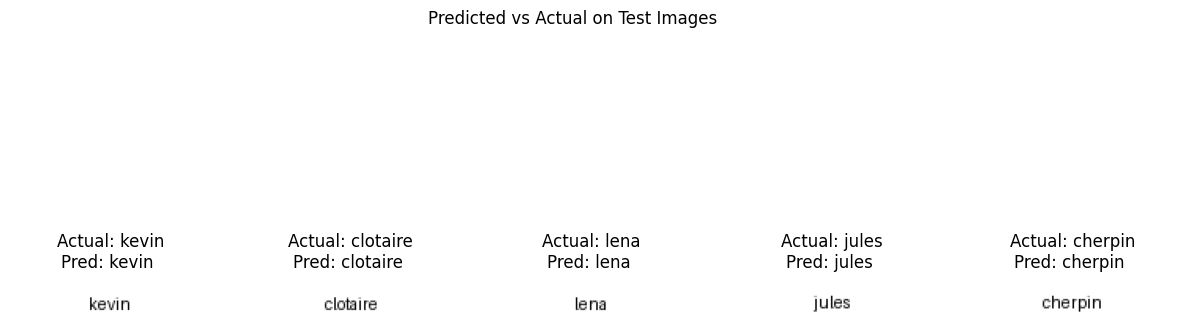

In [111]:
visualize_predictions(test_images[:5], actual_test_labels, predicted_test_labels, "Predicted vs Actual on Test Images")